# Synthetic data generation

In [1]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [2]:
import pandas as pd

In [3]:
from synthesized.core import BasicSynthesizer

Instructions for updating:
Use the retry module or similar alternatives.


## Load transactions

In [4]:
data = pd.read_csv('../data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [5]:
data = data[['type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,type,operation,amount
0,1,2,700.0
1,1,2,7268.0
2,1,2,14440.0
3,1,2,49752.0
4,1,2,21899.0
5,0,3,34700.0
7,1,2,30192.0
8,0,0,9612.0
9,1,2,31038.0
10,0,3,25200.0


## Train model and synthesized data

In [6]:
with BasicSynthesizer(
    dtypes=data.dtypes,
    encoding='variational', encoding_size=32, encoder=(32,), decoder=(32,)
) as synthesizer:
    synthesizer.learn(data=data, verbose=True)
    synthesized = synthesizer.synthesize(n=10000)

1: 2.20e+08
2: 2.19e+08
3: 2.01e+08
4: 1.24e+08
5: 1.04e+08
6: 1.84e+08
7: 6.72e+07
8: 6.25e+07
9: 1.96e+08
10: 2.14e+08
11: 1.75e+08
12: 1.75e+08
13: 1.11e+08
14: 1.60e+08
15: 1.86e+08
16: 9.22e+07
17: 1.71e+08
18: 1.51e+08
19: 1.38e+08
20: 2.35e+08
21: 8.24e+07
22: 1.17e+08
23: 7.97e+07
24: 1.14e+08
25: 1.29e+08
26: 9.77e+07
27: 3.19e+08
28: 1.97e+08
29: 1.28e+08
30: 1.81e+08
31: 2.40e+08
32: 1.81e+08
33: 2.04e+08
34: 1.08e+08
35: 1.47e+08
36: 1.69e+08
37: 1.73e+08
38: 9.45e+07
39: 1.34e+08
40: 1.78e+08
41: 4.35e+07
42: 1.74e+08
43: 1.87e+08
44: 1.73e+08
45: 1.68e+08
46: 5.78e+07
47: 1.87e+08
48: 1.31e+08
49: 1.96e+08
50: 1.93e+08
51: 8.37e+07
52: 2.19e+08
53: 1.31e+08
54: 1.12e+08
55: 1.15e+08
56: 1.05e+08
57: 1.21e+08
58: 7.72e+07
59: 1.72e+08
60: 2.25e+08
61: 9.70e+07
62: 9.21e+07
63: 1.37e+08
64: 1.46e+08
65: 1.65e+08
66: 1.92e+08
67: 1.83e+08
68: 7.08e+07
69: 1.01e+08
70: 1.52e+08
71: 1.20e+08
72: 2.19e+08
73: 1.35e+08
74: 1.22e+08
75: 1.32e+08
76: 1.84e+08
77: 2.36e+08
78: 1.20

598: 1.30e+08
599: 2.14e+08
600: 2.07e+08
601: 9.69e+07
602: 1.72e+08
603: 1.64e+08
604: 1.30e+08
605: 9.53e+07
606: 1.90e+08
607: 1.12e+08
608: 8.88e+07
609: 2.05e+08
610: 1.62e+08
611: 2.29e+08
612: 1.82e+08
613: 1.10e+08
614: 1.69e+08
615: 1.75e+08
616: 4.60e+07
617: 2.19e+08
618: 1.56e+08
619: 1.88e+08
620: 6.48e+07
621: 1.28e+08
622: 8.68e+07
623: 1.51e+08
624: 1.59e+08
625: 1.97e+08
626: 1.58e+08
627: 7.94e+07
628: 2.50e+08
629: 1.49e+08
630: 8.24e+07
631: 2.71e+08
632: 1.47e+08
633: 9.08e+07
634: 1.16e+08
635: 1.27e+08
636: 1.47e+08
637: 2.11e+08
638: 1.98e+08
639: 6.24e+07
640: 1.89e+08
641: 1.15e+08
642: 2.44e+08
643: 1.03e+08
644: 1.29e+08
645: 1.33e+08
646: 9.94e+07
647: 2.68e+08
648: 7.84e+07
649: 1.64e+08
650: 3.07e+08
651: 7.54e+07
652: 2.57e+08
653: 2.29e+08
654: 2.56e+08
655: 1.31e+08
656: 1.41e+08
657: 1.44e+08
658: 1.31e+08
659: 1.88e+08
660: 1.55e+08
661: 6.53e+07
662: 6.89e+07
663: 1.42e+08
664: 1.43e+08
665: 2.91e+08
666: 9.91e+07
667: 2.09e+08
668: 1.66e+08
669: 1

1206: 9.72e+07
1207: 1.63e+08
1208: 1.38e+08
1209: 9.69e+07
1210: 2.14e+08
1211: 1.14e+08
1212: 2.86e+08
1213: 1.94e+08
1214: 2.15e+08
1215: 1.35e+08
1216: 1.97e+08
1217: 1.22e+08
1218: 2.53e+08
1219: 1.53e+08
1220: 1.77e+08
1221: 9.50e+07
1222: 1.30e+08
1223: 2.24e+08
1224: 1.21e+08
1225: 1.56e+08
1226: 1.22e+08
1227: 1.44e+08
1228: 1.80e+08
1229: 2.27e+08
1230: 1.76e+08
1231: 1.38e+08
1232: 6.83e+07
1233: 1.17e+08
1234: 1.55e+08
1235: 5.17e+07
1236: 1.44e+08
1237: 2.01e+08
1238: 1.87e+08
1239: 2.20e+08
1240: 1.54e+08
1241: 7.80e+07
1242: 1.73e+08
1243: 2.55e+08
1244: 2.06e+08
1245: 2.49e+08
1246: 2.24e+08
1247: 1.41e+08
1248: 1.95e+08
1249: 2.88e+08
1250: 1.79e+08
1251: 1.78e+08
1252: 2.01e+08
1253: 9.70e+07
1254: 2.04e+08
1255: 9.73e+07
1256: 8.55e+07
1257: 2.05e+08
1258: 2.05e+08
1259: 1.16e+08
1260: 1.58e+08
1261: 1.63e+08
1262: 2.45e+08
1263: 7.33e+07
1264: 3.00e+08
1265: 7.02e+07
1266: 1.27e+08
1267: 1.01e+08
1268: 1.34e+08
1269: 1.53e+08
1270: 2.08e+08
1271: 8.73e+07
1272: 1.95

1769: 2.04e+08
1770: 1.41e+08
1771: 1.52e+08
1772: 1.28e+08
1773: 8.61e+07
1774: 1.09e+08
1775: 1.93e+08
1776: 1.82e+08
1777: 1.44e+08
1778: 1.72e+08
1779: 1.42e+08
1780: 2.13e+08
1781: 1.97e+08
1782: 1.12e+08
1783: 2.45e+08
1784: 1.49e+08
1785: 9.70e+07
1786: 2.81e+08
1787: 1.17e+08
1788: 1.73e+08
1789: 1.09e+08
1790: 1.03e+08
1791: 2.17e+08
1792: 1.28e+08
1793: 1.86e+08
1794: 1.17e+08
1795: 2.34e+08
1796: 1.74e+08
1797: 1.75e+08
1798: 9.30e+07
1799: 2.23e+08
1800: 2.51e+08
1801: 1.56e+08
1802: 2.35e+08
1803: 1.26e+08
1804: 1.47e+08
1805: 1.34e+08
1806: 2.49e+08
1807: 8.42e+07
1808: 1.45e+08
1809: 9.95e+07
1810: 2.27e+08
1811: 1.44e+08
1812: 1.00e+08
1813: 1.37e+08
1814: 1.27e+08
1815: 1.45e+08
1816: 1.20e+08
1817: 9.54e+07
1818: 1.47e+08
1819: 1.49e+08
1820: 1.25e+08
1821: 2.00e+08
1822: 8.94e+07
1823: 1.82e+08
1824: 1.33e+08
1825: 1.57e+08
1826: 9.55e+07
1827: 1.59e+08
1828: 1.90e+08
1829: 9.39e+07
1830: 9.65e+07
1831: 2.23e+08
1832: 1.05e+08
1833: 6.43e+07
1834: 2.70e+08
1835: 9.73

2359: 1.13e+08
2360: 1.68e+08
2361: 1.81e+08
2362: 1.26e+08
2363: 2.23e+08
2364: 1.28e+08
2365: 9.92e+07
2366: 9.88e+07
2367: 6.96e+07
2368: 1.25e+08
2369: 1.71e+08
2370: 1.13e+08
2371: 2.20e+08
2372: 1.26e+08
2373: 1.12e+08
2374: 1.45e+08
2375: 2.16e+08
2376: 1.77e+08
2377: 7.60e+07
2378: 1.84e+08
2379: 1.56e+08
2380: 1.80e+08
2381: 1.67e+08
2382: 1.88e+08
2383: 2.19e+08
2384: 2.04e+08
2385: 9.71e+07
2386: 2.63e+08
2387: 1.68e+08
2388: 1.11e+08
2389: 9.11e+07
2390: 1.62e+08
2391: 7.58e+07
2392: 1.05e+08
2393: 1.10e+08
2394: 1.86e+08
2395: 8.83e+07
2396: 1.85e+08
2397: 3.05e+08
2398: 1.39e+08
2399: 1.02e+08
2400: 1.48e+08
2401: 1.06e+08
2402: 1.51e+08
2403: 1.75e+08
2404: 1.06e+08
2405: 1.29e+08
2406: 1.51e+08
2407: 1.32e+08
2408: 2.36e+08
2409: 2.37e+08
2410: 8.71e+07
2411: 1.18e+08
2412: 2.72e+08
2413: 1.48e+08
2414: 6.09e+07
2415: 1.25e+08
2416: 1.86e+08
2417: 2.37e+08
2418: 1.21e+08
2419: 1.74e+08
2420: 1.51e+08
2421: 2.25e+08
2422: 1.98e+08
2423: 9.89e+07
2424: 2.12e+08
2425: 7.46

2933: 1.58e+08
2934: 2.36e+08
2935: 1.34e+08
2936: 1.00e+08
2937: 2.12e+08
2938: 1.69e+08
2939: 1.33e+08
2940: 1.39e+08
2941: 2.97e+08
2942: 1.28e+08
2943: 1.68e+08
2944: 1.18e+08
2945: 1.89e+08
2946: 1.41e+08
2947: 1.67e+08
2948: 1.49e+08
2949: 1.09e+08
2950: 2.67e+08
2951: 1.66e+08
2952: 1.41e+08
2953: 1.03e+08
2954: 1.99e+08
2955: 2.06e+08
2956: 1.42e+08
2957: 1.24e+08
2958: 1.57e+08
2959: 2.49e+08
2960: 1.26e+08
2961: 1.05e+08
2962: 1.56e+08
2963: 1.87e+08
2964: 2.18e+08
2965: 1.76e+08
2966: 1.04e+08
2967: 1.24e+08
2968: 2.82e+08
2969: 1.77e+08
2970: 1.77e+08
2971: 1.07e+08
2972: 5.66e+07
2973: 1.78e+08
2974: 1.62e+08
2975: 9.42e+07
2976: 1.46e+08
2977: 9.31e+07
2978: 1.70e+08
2979: 1.62e+08
2980: 1.11e+08
2981: 1.47e+08
2982: 1.66e+08
2983: 1.26e+08
2984: 1.01e+08
2985: 2.43e+08
2986: 1.91e+08
2987: 1.88e+08
2988: 1.80e+08
2989: 1.07e+08
2990: 1.52e+08
2991: 1.65e+08
2992: 1.12e+08
2993: 1.10e+08
2994: 1.21e+08
2995: 1.37e+08
2996: 9.24e+07
2997: 1.56e+08
2998: 1.09e+08
2999: 1.25

3530: 2.48e+08
3531: 1.16e+08
3532: 2.08e+08
3533: 1.09e+08
3534: 1.29e+08
3535: 2.14e+08
3536: 1.47e+08
3537: 9.53e+07
3538: 2.09e+08
3539: 8.68e+07
3540: 2.29e+08
3541: 1.62e+08
3542: 1.75e+08
3543: 2.43e+08
3544: 1.32e+08
3545: 1.47e+08
3546: 8.63e+07
3547: 2.11e+08
3548: 1.67e+08
3549: 1.33e+08
3550: 1.95e+08
3551: 8.75e+07
3552: 1.37e+08
3553: 1.60e+08
3554: 1.82e+08
3555: 1.24e+08
3556: 2.49e+08
3557: 1.65e+08
3558: 2.18e+08
3559: 7.71e+07
3560: 1.21e+08
3561: 1.34e+08
3562: 7.71e+07
3563: 1.64e+08
3564: 1.84e+08
3565: 1.07e+08
3566: 2.99e+08
3567: 1.20e+08
3568: 1.57e+08
3569: 1.93e+08
3570: 1.92e+08
3571: 1.53e+08
3572: 1.85e+08
3573: 2.26e+08
3574: 1.19e+08
3575: 1.52e+08
3576: 1.31e+08
3577: 2.56e+08
3578: 1.04e+08
3579: 2.17e+08
3580: 1.95e+08
3581: 2.14e+08
3582: 2.09e+08
3583: 7.77e+07
3584: 1.62e+08
3585: 1.87e+08
3586: 1.46e+08
3587: 1.30e+08
3588: 1.43e+08
3589: 9.91e+07
3590: 1.76e+08
3591: 2.03e+08
3592: 9.62e+07
3593: 1.81e+08
3594: 1.57e+08
3595: 1.12e+08
3596: 2.22

4081: 7.94e+07
4082: 1.79e+08
4083: 1.36e+08
4084: 1.52e+08
4085: 6.61e+07
4086: 2.23e+08
4087: 9.97e+07
4088: 2.10e+08
4089: 8.82e+07
4090: 9.97e+07
4091: 1.30e+08
4092: 1.45e+08
4093: 1.75e+08
4094: 1.35e+08
4095: 1.06e+08
4096: 1.61e+08
4097: 1.23e+08
4098: 1.44e+08
4099: 1.25e+08
4100: 2.34e+08
4101: 1.81e+08
4102: 2.43e+08
4103: 6.52e+07
4104: 2.07e+08
4105: 1.96e+08
4106: 1.04e+08
4107: 1.71e+08
4108: 1.80e+08
4109: 6.78e+07
4110: 8.29e+07
4111: 2.10e+08
4112: 1.79e+08
4113: 1.96e+08
4114: 1.46e+08
4115: 1.42e+08
4116: 2.12e+08
4117: 1.07e+08
4118: 1.96e+08
4119: 1.43e+08
4120: 8.71e+07
4121: 2.12e+08
4122: 2.33e+08
4123: 1.11e+08
4124: 1.54e+08
4125: 9.53e+07
4126: 1.74e+08
4127: 1.66e+08
4128: 9.89e+07
4129: 1.41e+08
4130: 1.56e+08
4131: 1.36e+08
4132: 9.90e+07
4133: 2.25e+08
4134: 9.52e+07
4135: 2.86e+08
4136: 1.42e+08
4137: 1.67e+08
4138: 1.16e+08
4139: 1.23e+08
4140: 1.54e+08
4141: 1.60e+08
4142: 1.57e+08
4143: 1.39e+08
4144: 1.56e+08
4145: 1.60e+08
4146: 1.26e+08
4147: 1.32

4702: 1.51e+08
4703: 6.84e+07
4704: 9.13e+07
4705: 1.49e+08
4706: 1.58e+08
4707: 1.26e+08
4708: 8.09e+07
4709: 2.04e+08
4710: 1.33e+08
4711: 1.48e+08
4712: 1.25e+08
4713: 1.62e+08
4714: 1.19e+08
4715: 1.33e+08
4716: 1.19e+08
4717: 1.57e+08
4718: 1.03e+08
4719: 1.45e+08
4720: 6.84e+07
4721: 1.57e+08
4722: 1.31e+08
4723: 2.07e+08
4724: 1.86e+08
4725: 1.52e+08
4726: 1.52e+08
4727: 1.67e+08
4728: 1.18e+08
4729: 1.70e+08
4730: 1.30e+08
4731: 2.18e+08
4732: 1.57e+08
4733: 1.23e+08
4734: 1.07e+08
4735: 2.06e+08
4736: 1.07e+08
4737: 1.49e+08
4738: 2.52e+08
4739: 1.70e+08
4740: 9.10e+07
4741: 1.74e+08
4742: 1.81e+08
4743: 1.90e+08
4744: 1.23e+08
4745: 2.29e+08
4746: 1.20e+08
4747: 1.11e+08
4748: 1.53e+08
4749: 1.57e+08
4750: 1.91e+08
4751: 1.51e+08
4752: 2.21e+08
4753: 2.15e+08
4754: 1.21e+08
4755: 1.84e+08
4756: 2.12e+08
4757: 1.89e+08
4758: 1.13e+08
4759: 2.44e+08
4760: 2.59e+08
4761: 2.10e+08
4762: 2.19e+08
4763: 1.20e+08
4764: 1.24e+08
4765: 7.81e+07
4766: 1.20e+08
4767: 1.63e+08
4768: 1.05

5342: 1.17e+08
5343: 2.16e+08
5344: 7.36e+07
5345: 1.55e+08
5346: 8.04e+07
5347: 8.15e+07
5348: 9.87e+07
5349: 1.32e+08
5350: 2.18e+08
5351: 9.50e+07
5352: 8.78e+07
5353: 2.96e+08
5354: 9.15e+07
5355: 9.63e+07
5356: 7.39e+07
5357: 3.24e+08
5358: 1.18e+08
5359: 2.68e+08
5360: 2.65e+08
5361: 1.08e+08
5362: 9.00e+07
5363: 2.14e+08
5364: 1.71e+08
5365: 1.66e+08
5366: 1.54e+08
5367: 9.10e+07
5368: 1.13e+08
5369: 1.08e+08
5370: 9.04e+07
5371: 2.04e+08
5372: 1.07e+08
5373: 8.34e+07
5374: 8.66e+07
5375: 1.21e+08
5376: 1.32e+08
5377: 2.06e+08
5378: 1.67e+08
5379: 1.45e+08
5380: 1.64e+08
5381: 1.47e+08
5382: 1.67e+08
5383: 9.17e+07
5384: 1.65e+08
5385: 1.12e+08
5386: 1.72e+08
5387: 7.51e+07
5388: 1.06e+08
5389: 3.50e+08
5390: 1.13e+08
5391: 1.18e+08
5392: 4.17e+07
5393: 1.11e+08
5394: 1.12e+08
5395: 1.71e+08
5396: 1.44e+08
5397: 9.17e+07
5398: 8.18e+07
5399: 2.59e+08
5400: 1.83e+08
5401: 2.02e+08
5402: 1.20e+08
5403: 1.62e+08
5404: 1.24e+08
5405: 2.00e+08
5406: 9.10e+07
5407: 1.80e+08
5408: 7.73

5966: 2.22e+08
5967: 2.47e+08
5968: 2.04e+08
5969: 1.81e+08
5970: 1.68e+08
5971: 1.46e+08
5972: 1.31e+08
5973: 1.21e+08
5974: 2.30e+08
5975: 2.19e+08
5976: 1.30e+08
5977: 9.64e+07
5978: 1.69e+08
5979: 1.32e+08
5980: 2.66e+08
5981: 1.22e+08
5982: 1.87e+08
5983: 9.05e+07
5984: 1.79e+08
5985: 1.43e+08
5986: 1.94e+08
5987: 3.28e+08
5988: 1.60e+08
5989: 2.15e+08
5990: 1.56e+08
5991: 1.19e+08
5992: 1.36e+08
5993: 1.93e+08
5994: 1.50e+08
5995: 1.14e+08
5996: 1.47e+08
5997: 1.18e+08
5998: 1.25e+08
5999: 1.68e+08
6000: 1.35e+08
6001: 6.59e+07
6002: 1.13e+08
6003: 1.61e+08
6004: 1.38e+08
6005: 1.47e+08
6006: 2.05e+08
6007: 8.08e+07
6008: 2.13e+08
6009: 2.12e+08
6010: 1.71e+08
6011: 1.49e+08
6012: 1.42e+08
6013: 1.09e+08
6014: 1.67e+08
6015: 2.60e+08
6016: 1.55e+08
6017: 2.56e+08
6018: 1.14e+08
6019: 1.50e+08
6020: 2.02e+08
6021: 1.93e+08
6022: 1.61e+08
6023: 1.69e+08
6024: 8.40e+07
6025: 1.70e+08
6026: 1.50e+08
6027: 5.72e+07
6028: 1.89e+08
6029: 8.46e+07
6030: 2.31e+08
6031: 2.27e+08
6032: 1.24

6552: 1.07e+08
6553: 6.11e+07
6554: 1.37e+08
6555: 1.15e+08
6556: 3.05e+08
6557: 2.22e+08
6558: 1.50e+08
6559: 2.38e+08
6560: 1.07e+08
6561: 1.61e+08
6562: 1.41e+08
6563: 7.06e+07
6564: 1.82e+08
6565: 1.27e+08
6566: 1.17e+08
6567: 8.63e+07
6568: 1.82e+08
6569: 1.33e+08
6570: 1.25e+08
6571: 1.45e+08
6572: 1.96e+08
6573: 1.67e+08
6574: 1.56e+08
6575: 2.05e+08
6576: 8.72e+07
6577: 9.32e+07
6578: 1.75e+08
6579: 5.74e+07
6580: 1.17e+08
6581: 9.90e+07
6582: 1.95e+08
6583: 2.28e+08
6584: 1.37e+08
6585: 1.44e+08
6586: 1.68e+08
6587: 7.54e+07
6588: 1.39e+08
6589: 6.92e+07
6590: 1.43e+08
6591: 1.40e+08
6592: 1.92e+08
6593: 1.24e+08
6594: 1.59e+08
6595: 1.82e+08
6596: 7.93e+07
6597: 1.86e+08
6598: 1.75e+08
6599: 7.23e+07
6600: 1.61e+08
6601: 1.52e+08
6602: 1.26e+08
6603: 2.04e+08
6604: 1.50e+08
6605: 1.44e+08
6606: 1.30e+08
6607: 1.30e+08
6608: 1.65e+08
6609: 8.16e+07
6610: 1.30e+08
6611: 7.67e+07
6612: 1.66e+08
6613: 1.79e+08
6614: 6.30e+07
6615: 1.72e+08
6616: 1.66e+08
6617: 7.08e+07
6618: 1.32

7105: 1.11e+08
7106: 1.73e+08
7107: 1.90e+08
7108: 1.47e+08
7109: 1.59e+08
7110: 1.96e+08
7111: 1.48e+08
7112: 1.25e+08
7113: 1.12e+08
7114: 2.25e+08
7115: 1.80e+08
7116: 8.33e+07
7117: 1.81e+08
7118: 1.51e+08
7119: 1.04e+08
7120: 1.26e+08
7121: 2.16e+08
7122: 3.07e+08
7123: 1.52e+08
7124: 1.72e+08
7125: 9.29e+07
7126: 1.12e+08
7127: 1.58e+08
7128: 2.02e+08
7129: 1.25e+08
7130: 7.80e+07
7131: 1.54e+08
7132: 2.87e+08
7133: 1.89e+08
7134: 1.00e+08
7135: 1.67e+08
7136: 1.41e+08
7137: 9.44e+07
7138: 1.41e+08
7139: 1.39e+08
7140: 1.37e+08
7141: 1.69e+08
7142: 1.75e+08
7143: 1.57e+08
7144: 1.46e+08
7145: 2.36e+08
7146: 1.99e+08
7147: 9.49e+07
7148: 1.20e+08
7149: 1.15e+08
7150: 1.00e+08
7151: 1.78e+08
7152: 1.90e+08
7153: 6.16e+07
7154: 1.09e+08
7155: 2.38e+08
7156: 1.41e+08
7157: 1.02e+08
7158: 9.35e+07
7159: 1.77e+08
7160: 1.07e+08
7161: 1.48e+08
7162: 2.28e+08
7163: 1.11e+08
7164: 1.92e+08
7165: 1.87e+08
7166: 1.52e+08
7167: 1.67e+08
7168: 1.93e+08
7169: 9.43e+07
7170: 2.04e+08
7171: 1.10

7667: 1.43e+08
7668: 3.60e+08
7669: 2.55e+08
7670: 1.28e+08
7671: 1.52e+08
7672: 1.19e+08
7673: 8.87e+07
7674: 9.98e+07
7675: 1.61e+08
7676: 1.32e+08
7677: 2.27e+08
7678: 1.36e+08
7679: 1.43e+08
7680: 1.23e+08
7681: 1.90e+08
7682: 2.06e+08
7683: 1.25e+08
7684: 2.04e+08
7685: 1.51e+08
7686: 2.21e+08
7687: 8.54e+07
7688: 6.37e+07
7689: 1.24e+08
7690: 4.55e+07
7691: 8.20e+07
7692: 1.23e+08
7693: 1.20e+08
7694: 8.96e+07
7695: 1.38e+08
7696: 1.49e+08
7697: 2.35e+08
7698: 1.36e+08
7699: 1.43e+08
7700: 9.94e+07
7701: 1.21e+08
7702: 6.18e+07
7703: 1.73e+08
7704: 1.53e+08
7705: 1.30e+08
7706: 2.35e+08
7707: 9.04e+07
7708: 1.45e+08
7709: 1.41e+08
7710: 1.57e+08
7711: 1.47e+08
7712: 7.32e+07
7713: 1.63e+08
7714: 1.51e+08
7715: 1.53e+08
7716: 1.95e+08
7717: 1.96e+08
7718: 1.72e+08
7719: 7.50e+07
7720: 1.54e+08
7721: 1.76e+08
7722: 1.34e+08
7723: 1.72e+08
7724: 1.03e+08
7725: 1.43e+08
7726: 1.86e+08
7727: 1.35e+08
7728: 1.48e+08
7729: 1.36e+08
7730: 1.85e+08
7731: 9.37e+07
7732: 9.49e+07
7733: 1.64

8237: 1.89e+08
8238: 1.67e+08
8239: 1.21e+08
8240: 1.37e+08
8241: 1.80e+08
8242: 1.99e+08
8243: 1.72e+08
8244: 7.74e+07
8245: 6.03e+07
8246: 1.45e+08
8247: 1.14e+08
8248: 1.01e+08
8249: 1.62e+08
8250: 1.37e+08
8251: 1.56e+08
8252: 1.31e+08
8253: 1.94e+08
8254: 1.86e+08
8255: 2.28e+08
8256: 4.56e+07
8257: 2.35e+08
8258: 1.41e+08
8259: 6.04e+07
8260: 1.31e+08
8261: 1.08e+08
8262: 1.12e+08
8263: 5.70e+07
8264: 1.12e+08
8265: 6.56e+07
8266: 8.23e+07
8267: 8.94e+07
8268: 1.29e+08
8269: 1.39e+08
8270: 2.31e+08
8271: 1.13e+08
8272: 1.29e+08
8273: 1.44e+08
8274: 1.24e+08
8275: 1.21e+08
8276: 1.07e+08
8277: 1.12e+08
8278: 1.33e+08
8279: 1.31e+08
8280: 9.01e+07
8281: 1.53e+08
8282: 1.01e+08
8283: 1.30e+08
8284: 9.97e+07
8285: 1.91e+08
8286: 1.28e+08
8287: 1.11e+08
8288: 1.63e+08
8289: 1.53e+08
8290: 1.34e+08
8291: 1.19e+08
8292: 6.36e+07
8293: 1.76e+08
8294: 1.18e+08
8295: 2.10e+08
8296: 1.62e+08
8297: 1.43e+08
8298: 1.52e+08
8299: 1.69e+08
8300: 1.80e+08
8301: 1.37e+08
8302: 1.12e+08
8303: 1.75

8832: 8.60e+07
8833: 2.16e+08
8834: 8.85e+07
8835: 1.17e+08
8836: 1.68e+08
8837: 1.43e+08
8838: 1.61e+08
8839: 1.84e+08
8840: 1.30e+08
8841: 1.01e+08
8842: 1.76e+08
8843: 1.34e+08
8844: 1.61e+08
8845: 1.56e+08
8846: 1.10e+08
8847: 2.32e+08
8848: 9.17e+07
8849: 1.13e+08
8850: 1.16e+08
8851: 9.16e+07
8852: 1.29e+08
8853: 1.37e+08
8854: 4.79e+07
8855: 1.20e+08
8856: 1.16e+08
8857: 2.36e+08
8858: 2.31e+08
8859: 1.14e+08
8860: 1.76e+08
8861: 6.81e+07
8862: 1.17e+08
8863: 1.91e+08
8864: 1.27e+08
8865: 2.01e+08
8866: 1.99e+08
8867: 1.79e+08
8868: 1.09e+08
8869: 1.20e+08
8870: 2.06e+08
8871: 1.48e+08
8872: 2.00e+08
8873: 5.43e+07
8874: 1.38e+08
8875: 1.87e+08
8876: 2.05e+08
8877: 1.58e+08
8878: 9.71e+07
8879: 1.52e+08
8880: 7.03e+07
8881: 1.70e+08
8882: 1.17e+08
8883: 1.18e+08
8884: 1.61e+08
8885: 1.62e+08
8886: 5.76e+07
8887: 1.12e+08
8888: 1.98e+08
8889: 1.63e+08
8890: 1.11e+08
8891: 1.06e+08
8892: 1.13e+08
8893: 1.27e+08
8894: 7.65e+07
8895: 1.38e+08
8896: 1.03e+08
8897: 1.67e+08
8898: 1.95

9392: 9.82e+07
9393: 1.78e+08
9394: 1.33e+08
9395: 2.05e+08
9396: 1.95e+08
9397: 1.20e+08
9398: 1.70e+08
9399: 1.17e+08
9400: 1.05e+08
9401: 1.44e+08
9402: 2.13e+08
9403: 1.97e+08
9404: 1.11e+08
9405: 1.15e+08
9406: 1.18e+08
9407: 1.67e+08
9408: 1.61e+08
9409: 1.36e+08
9410: 1.25e+08
9411: 2.22e+08
9412: 1.88e+08
9413: 1.19e+08
9414: 1.33e+08
9415: 4.53e+07
9416: 1.95e+08
9417: 1.45e+08
9418: 1.77e+08
9419: 1.09e+08
9420: 2.18e+08
9421: 1.46e+08
9422: 1.68e+08
9423: 1.88e+08
9424: 1.36e+08
9425: 1.21e+08
9426: 2.01e+08
9427: 1.26e+08
9428: 1.74e+08
9429: 1.53e+08
9430: 1.88e+08
9431: 1.01e+08
9432: 1.82e+08
9433: 2.38e+08
9434: 1.98e+08
9435: 1.43e+08
9436: 2.01e+08
9437: 1.36e+08
9438: 7.33e+07
9439: 1.05e+08
9440: 2.09e+08
9441: 1.37e+08
9442: 8.29e+07
9443: 1.51e+08
9444: 1.06e+08
9445: 8.72e+07
9446: 1.13e+08
9447: 2.79e+08
9448: 2.17e+08
9449: 1.02e+08
9450: 2.16e+08
9451: 1.32e+08
9452: 1.11e+08
9453: 1.60e+08
9454: 1.64e+08
9455: 2.82e+08
9456: 1.02e+08
9457: 1.13e+08
9458: 1.57

10016: 1.42e+08
10017: 1.08e+08
10018: 1.06e+08
10019: 2.26e+08
10020: 1.33e+08
10021: 4.26e+07
10022: 1.10e+08
10023: 1.07e+08
10024: 2.65e+08
10025: 1.53e+08
10026: 1.66e+08
10027: 1.36e+08
10028: 2.03e+08
10029: 1.79e+08
10030: 1.05e+08
10031: 1.68e+08
10032: 8.06e+07
10033: 1.51e+08
10034: 1.87e+08
10035: 1.66e+08
10036: 8.13e+07
10037: 1.24e+08
10038: 1.08e+08
10039: 1.02e+08
10040: 1.73e+08
10041: 9.53e+07
10042: 1.57e+08
10043: 9.30e+07
10044: 1.38e+08
10045: 1.28e+08
10046: 1.36e+08
10047: 8.85e+07
10048: 7.41e+07
10049: 8.07e+07
10050: 1.72e+08
10051: 1.94e+08
10052: 2.08e+08
10053: 1.35e+08
10054: 1.35e+08
10055: 6.53e+07
10056: 1.07e+08
10057: 1.66e+08
10058: 1.23e+08
10059: 1.27e+08
10060: 2.20e+08
10061: 1.14e+08
10062: 1.10e+08
10063: 1.99e+08
10064: 1.48e+08
10065: 1.29e+08
10066: 8.93e+07
10067: 8.18e+07
10068: 1.33e+08
10069: 1.29e+08
10070: 2.32e+08
10071: 1.33e+08
10072: 1.50e+08
10073: 1.29e+08
10074: 1.76e+08
10075: 1.59e+08
10076: 1.42e+08
10077: 9.89e+07
10078: 1

10633: 2.52e+08
10634: 8.78e+07
10635: 1.90e+08
10636: 1.59e+08
10637: 1.85e+08
10638: 9.87e+07
10639: 1.69e+08
10640: 1.13e+08
10641: 1.15e+08
10642: 1.65e+08
10643: 1.81e+08
10644: 1.20e+08
10645: 2.07e+08
10646: 1.07e+08
10647: 1.52e+08
10648: 1.05e+08
10649: 1.03e+08
10650: 1.00e+08
10651: 1.26e+08
10652: 1.45e+08
10653: 1.95e+08
10654: 4.65e+07
10655: 9.79e+07
10656: 1.30e+08
10657: 7.98e+07
10658: 9.02e+07
10659: 1.63e+08
10660: 7.48e+07
10661: 1.27e+08
10662: 8.73e+07
10663: 2.84e+08
10664: 8.85e+07
10665: 1.66e+08
10666: 1.51e+08
10667: 1.21e+08
10668: 2.12e+08
10669: 1.45e+08
10670: 2.08e+08
10671: 1.53e+08
10672: 1.57e+08
10673: 6.81e+07
10674: 1.55e+08
10675: 7.48e+07
10676: 1.00e+08
10677: 7.48e+07
10678: 7.51e+07
10679: 2.41e+08
10680: 1.07e+08
10681: 1.50e+08
10682: 1.46e+08
10683: 1.60e+08
10684: 1.84e+08
10685: 8.40e+07
10686: 1.97e+08
10687: 1.05e+08
10688: 1.10e+08
10689: 9.69e+07
10690: 1.15e+08
10691: 2.98e+08
10692: 1.50e+08
10693: 1.50e+08
10694: 1.79e+08
10695: 5

11153: 1.81e+08
11154: 8.93e+07
11155: 1.75e+08
11156: 8.34e+07
11157: 1.16e+08
11158: 1.94e+08
11159: 9.29e+07
11160: 1.42e+08
11161: 5.78e+07
11162: 1.72e+08
11163: 1.14e+08
11164: 1.90e+08
11165: 1.71e+08
11166: 1.98e+08
11167: 2.10e+08
11168: 1.44e+08
11169: 1.93e+08
11170: 1.23e+08
11171: 1.71e+08
11172: 1.26e+08
11173: 7.69e+07
11174: 1.30e+08
11175: 1.30e+08
11176: 9.64e+07
11177: 2.05e+08
11178: 2.63e+08
11179: 1.89e+08
11180: 1.44e+08
11181: 1.77e+08
11182: 1.15e+08
11183: 7.79e+07
11184: 1.24e+08
11185: 1.39e+08
11186: 1.47e+08
11187: 1.05e+08
11188: 7.37e+07
11189: 9.35e+07
11190: 1.00e+08
11191: 8.33e+07
11192: 2.44e+08
11193: 2.10e+08
11194: 1.11e+08
11195: 1.21e+08
11196: 5.94e+07
11197: 2.45e+08
11198: 2.35e+08
11199: 8.70e+07
11200: 6.90e+07
11201: 2.00e+08
11202: 1.19e+08
11203: 2.12e+08
11204: 9.56e+07
11205: 1.55e+08
11206: 8.64e+07
11207: 1.18e+08
11208: 1.16e+08
11209: 1.77e+08
11210: 1.30e+08
11211: 1.44e+08
11212: 1.42e+08
11213: 1.03e+08
11214: 1.53e+08
11215: 2

11691: 2.22e+08
11692: 2.39e+08
11693: 1.24e+08
11694: 1.41e+08
11695: 7.13e+07
11696: 7.43e+07
11697: 1.70e+08
11698: 1.76e+08
11699: 2.03e+08
11700: 1.30e+08
11701: 1.71e+08
11702: 1.78e+08
11703: 1.02e+08
11704: 1.72e+08
11705: 2.17e+08
11706: 1.25e+08
11707: 1.00e+08
11708: 1.32e+08
11709: 1.80e+08
11710: 2.27e+08
11711: 1.41e+08
11712: 9.17e+07
11713: 1.51e+08
11714: 1.66e+08
11715: 1.81e+08
11716: 9.73e+07
11717: 1.38e+08
11718: 1.69e+08
11719: 1.04e+08
11720: 2.14e+08
11721: 1.74e+08
11722: 1.12e+08
11723: 1.11e+08
11724: 1.09e+08
11725: 1.15e+08
11726: 1.11e+08
11727: 1.70e+08
11728: 1.47e+08
11729: 1.80e+08
11730: 1.09e+08
11731: 5.92e+07
11732: 1.38e+08
11733: 2.76e+08
11734: 2.20e+08
11735: 8.31e+07
11736: 9.47e+07
11737: 1.53e+08
11738: 1.30e+08
11739: 1.72e+08
11740: 1.19e+08
11741: 1.92e+08
11742: 1.82e+08
11743: 1.28e+08
11744: 1.92e+08
11745: 1.42e+08
11746: 1.51e+08
11747: 1.23e+08
11748: 2.38e+08
11749: 1.81e+08
11750: 1.66e+08
11751: 5.94e+07
11752: 1.45e+08
11753: 9

12273: 2.08e+08
12274: 2.07e+08
12275: 1.38e+08
12276: 2.15e+08
12277: 9.85e+07
12278: 1.95e+08
12279: 1.17e+08
12280: 1.48e+08
12281: 1.47e+08
12282: 1.76e+08
12283: 9.99e+07
12284: 1.16e+08
12285: 1.14e+08
12286: 1.57e+08
12287: 7.15e+07
12288: 1.65e+08
12289: 2.19e+08
12290: 7.12e+07
12291: 9.36e+07
12292: 1.77e+08
12293: 1.66e+08
12294: 4.77e+07
12295: 1.19e+08
12296: 1.22e+08
12297: 7.03e+07
12298: 1.12e+08
12299: 1.33e+08
12300: 1.93e+08
12301: 1.92e+08
12302: 8.09e+07
12303: 1.86e+08
12304: 1.10e+08
12305: 1.36e+08
12306: 1.34e+08
12307: 1.81e+08
12308: 2.01e+08
12309: 8.64e+07
12310: 1.54e+08
12311: 1.62e+08
12312: 8.21e+07
12313: 2.12e+08
12314: 1.33e+08
12315: 6.41e+07
12316: 2.38e+08
12317: 8.00e+07
12318: 1.19e+08
12319: 6.99e+07
12320: 6.78e+07
12321: 2.06e+08
12322: 1.17e+08
12323: 1.28e+08
12324: 1.46e+08
12325: 2.19e+08
12326: 1.84e+08
12327: 1.53e+08
12328: 1.47e+08
12329: 1.32e+08
12330: 1.27e+08
12331: 2.36e+08
12332: 1.27e+08
12333: 2.29e+08
12334: 9.06e+07
12335: 2

12805: 2.00e+08
12806: 2.81e+08
12807: 1.57e+08
12808: 8.34e+07
12809: 1.93e+08
12810: 1.90e+08
12811: 1.18e+08
12812: 1.89e+08
12813: 2.30e+08
12814: 1.08e+08
12815: 7.10e+07
12816: 1.21e+08
12817: 1.52e+08
12818: 2.41e+08
12819: 1.22e+08
12820: 1.70e+08
12821: 1.11e+08
12822: 7.54e+07
12823: 1.43e+08
12824: 1.83e+08
12825: 3.20e+08
12826: 5.59e+07
12827: 8.33e+07
12828: 7.43e+07
12829: 1.48e+08
12830: 1.32e+08
12831: 2.71e+08
12832: 1.56e+08
12833: 1.37e+08
12834: 8.54e+07
12835: 2.01e+08
12836: 1.41e+08
12837: 1.16e+08
12838: 1.49e+08
12839: 8.97e+07
12840: 2.33e+08
12841: 9.33e+07
12842: 1.48e+08
12843: 9.77e+07
12844: 4.08e+08
12845: 1.21e+08
12846: 1.53e+08
12847: 1.52e+08
12848: 9.89e+07
12849: 1.69e+08
12850: 1.58e+08
12851: 1.13e+08
12852: 1.66e+08
12853: 1.57e+08
12854: 1.17e+08
12855: 2.03e+08
12856: 1.12e+08
12857: 1.37e+08
12858: 5.99e+07
12859: 8.80e+07
12860: 6.86e+07
12861: 1.27e+08
12862: 1.18e+08
12863: 1.07e+08
12864: 9.85e+07
12865: 1.42e+08
12866: 1.68e+08
12867: 1

13395: 2.04e+08
13396: 1.91e+08
13397: 1.07e+08
13398: 1.81e+08
13399: 1.52e+08
13400: 2.25e+08
13401: 9.61e+07
13402: 9.11e+07
13403: 5.10e+07
13404: 1.14e+08
13405: 7.52e+07
13406: 1.20e+08
13407: 1.13e+08
13408: 1.15e+08
13409: 2.01e+08
13410: 1.11e+08
13411: 6.45e+07
13412: 1.14e+08
13413: 1.63e+08
13414: 1.48e+08
13415: 1.37e+08
13416: 2.29e+08
13417: 1.73e+08
13418: 1.02e+08
13419: 1.13e+08
13420: 1.61e+08
13421: 1.00e+08
13422: 8.27e+07
13423: 2.56e+08
13424: 1.79e+08
13425: 1.43e+08
13426: 1.56e+08
13427: 1.25e+08
13428: 7.79e+07
13429: 6.07e+07
13430: 2.45e+08
13431: 8.61e+07
13432: 1.63e+08
13433: 1.28e+08
13434: 1.69e+08
13435: 1.28e+08
13436: 1.79e+08
13437: 8.94e+07
13438: 1.42e+08
13439: 1.10e+08
13440: 1.24e+08
13441: 1.97e+08
13442: 8.25e+07
13443: 1.86e+08
13444: 5.08e+07
13445: 1.61e+08
13446: 1.67e+08
13447: 2.04e+08
13448: 2.32e+08
13449: 1.56e+08
13450: 9.16e+07
13451: 1.67e+08
13452: 1.36e+08
13453: 1.19e+08
13454: 6.38e+07
13455: 1.49e+08
13456: 1.46e+08
13457: 8

13942: 2.77e+08
13943: 1.23e+08
13944: 9.40e+07
13945: 1.69e+08
13946: 1.82e+08
13947: 1.55e+08
13948: 1.79e+08
13949: 1.62e+08
13950: 1.50e+08
13951: 2.07e+08
13952: 1.40e+08
13953: 9.32e+07
13954: 1.12e+08
13955: 9.68e+07
13956: 1.34e+08
13957: 1.93e+08
13958: 1.01e+08
13959: 9.25e+07
13960: 1.65e+08
13961: 1.33e+08
13962: 1.45e+08
13963: 1.54e+08
13964: 1.37e+08
13965: 6.61e+07
13966: 1.97e+08
13967: 1.23e+08
13968: 8.70e+07
13969: 1.57e+08
13970: 9.61e+07
13971: 1.80e+08
13972: 1.69e+08
13973: 2.03e+08
13974: 1.19e+08
13975: 1.13e+08
13976: 1.58e+08
13977: 3.16e+08
13978: 1.21e+08
13979: 2.29e+08
13980: 9.29e+07
13981: 9.62e+07
13982: 7.61e+07
13983: 1.07e+08
13984: 1.23e+08
13985: 1.08e+08
13986: 6.36e+07
13987: 1.93e+08
13988: 7.50e+07
13989: 2.59e+08
13990: 5.38e+07
13991: 2.69e+08
13992: 1.20e+08
13993: 1.12e+08
13994: 1.59e+08
13995: 1.63e+08
13996: 1.09e+08
13997: 1.01e+08
13998: 7.58e+07
13999: 1.59e+08
14000: 1.66e+08
14001: 1.69e+08
14002: 1.56e+08
14003: 1.84e+08
14004: 1

14500: 1.49e+08
14501: 1.46e+08
14502: 2.30e+08
14503: 5.90e+07
14504: 1.15e+08
14505: 1.42e+08
14506: 1.73e+08
14507: 1.52e+08
14508: 2.01e+08
14509: 1.37e+08
14510: 1.19e+08
14511: 1.21e+08
14512: 9.73e+07
14513: 1.30e+08
14514: 7.47e+07
14515: 1.24e+08
14516: 1.20e+08
14517: 1.89e+08
14518: 1.07e+08
14519: 9.70e+07
14520: 1.84e+08
14521: 9.95e+07
14522: 1.08e+08
14523: 1.55e+08
14524: 5.90e+07
14525: 9.86e+07
14526: 2.49e+08
14527: 1.31e+08
14528: 6.17e+07
14529: 2.07e+08
14530: 1.39e+08
14531: 1.23e+08
14532: 1.61e+08
14533: 9.54e+07
14534: 1.36e+08
14535: 1.87e+08
14536: 1.84e+08
14537: 1.24e+08
14538: 8.39e+07
14539: 1.67e+08
14540: 1.41e+08
14541: 1.11e+08
14542: 1.40e+08
14543: 1.14e+08
14544: 9.21e+07
14545: 2.15e+08
14546: 2.24e+08
14547: 2.23e+08
14548: 1.07e+08
14549: 1.53e+08
14550: 4.68e+07
14551: 2.01e+08
14552: 8.85e+07
14553: 6.22e+07
14554: 1.04e+08
14555: 1.50e+08
14556: 1.37e+08
14557: 7.87e+07
14558: 1.59e+08
14559: 1.12e+08
14560: 2.09e+08
14561: 1.65e+08
14562: 1

15061: 1.73e+08
15062: 3.49e+07
15063: 7.23e+07
15064: 1.47e+08
15065: 1.41e+08
15066: 1.47e+08
15067: 1.64e+08
15068: 8.06e+07
15069: 1.41e+08
15070: 4.90e+07
15071: 1.38e+08
15072: 1.37e+08
15073: 1.07e+08
15074: 9.82e+07
15075: 2.45e+08
15076: 1.04e+08
15077: 1.33e+08
15078: 2.22e+08
15079: 1.83e+08
15080: 1.91e+08
15081: 1.24e+08
15082: 1.03e+08
15083: 1.54e+08
15084: 1.01e+08
15085: 2.23e+08
15086: 1.40e+08
15087: 1.05e+08
15088: 8.73e+07
15089: 1.26e+08
15090: 1.43e+08
15091: 4.69e+07
15092: 1.58e+08
15093: 2.02e+08
15094: 1.74e+08
15095: 1.79e+08
15096: 1.36e+08
15097: 1.80e+08
15098: 8.65e+07
15099: 1.40e+08
15100: 1.63e+08
15101: 6.06e+07
15102: 1.95e+08
15103: 1.10e+08
15104: 6.48e+07
15105: 2.11e+08
15106: 1.38e+08
15107: 1.01e+08
15108: 1.52e+08
15109: 1.29e+08
15110: 1.91e+08
15111: 1.30e+08
15112: 1.28e+08
15113: 1.20e+08
15114: 1.29e+08
15115: 2.45e+08
15116: 1.72e+08
15117: 1.03e+08
15118: 2.51e+08
15119: 1.03e+08
15120: 1.38e+08
15121: 2.29e+08
15122: 1.35e+08
15123: 1

15575: 1.33e+08
15576: 1.35e+08
15577: 1.52e+08
15578: 8.34e+07
15579: 2.01e+08
15580: 1.12e+08
15581: 2.17e+08
15582: 1.63e+08
15583: 2.02e+08
15584: 1.71e+08
15585: 1.51e+08
15586: 1.47e+08
15587: 1.33e+08
15588: 1.23e+08
15589: 9.47e+07
15590: 9.97e+07
15591: 1.78e+08
15592: 1.92e+08
15593: 1.81e+08
15594: 1.81e+08
15595: 2.42e+08
15596: 1.63e+08
15597: 6.66e+07
15598: 1.55e+08
15599: 1.30e+08
15600: 1.97e+08
15601: 1.25e+08
15602: 1.02e+08
15603: 1.25e+08
15604: 1.08e+08
15605: 2.14e+08
15606: 1.52e+08
15607: 1.57e+08
15608: 1.60e+08
15609: 1.63e+08
15610: 1.25e+08
15611: 1.41e+08
15612: 1.81e+08
15613: 1.44e+08
15614: 1.41e+08
15615: 1.47e+08
15616: 1.26e+08
15617: 6.97e+07
15618: 1.04e+08
15619: 1.90e+08
15620: 1.63e+08
15621: 2.00e+08
15622: 1.91e+08
15623: 1.37e+08
15624: 1.32e+08
15625: 1.58e+08
15626: 1.13e+08
15627: 1.56e+08
15628: 1.28e+08
15629: 1.17e+08
15630: 2.24e+08
15631: 1.48e+08
15632: 1.59e+08
15633: 1.06e+08
15634: 1.04e+08
15635: 8.25e+07
15636: 1.20e+08
15637: 9

16154: 1.71e+08
16155: 1.34e+08
16156: 1.41e+08
16157: 6.64e+07
16158: 2.02e+08
16159: 9.41e+07
16160: 1.94e+08
16161: 4.53e+07
16162: 1.17e+08
16163: 2.11e+08
16164: 5.57e+07
16165: 2.22e+08
16166: 1.12e+08
16167: 1.33e+08
16168: 7.41e+07
16169: 6.27e+07
16170: 1.18e+08
16171: 1.09e+08
16172: 1.16e+08
16173: 1.33e+08
16174: 1.62e+08
16175: 2.44e+08
16176: 1.09e+08
16177: 1.22e+08
16178: 1.36e+08
16179: 8.77e+07
16180: 1.44e+08
16181: 1.20e+08
16182: 2.03e+08
16183: 7.98e+07
16184: 1.47e+08
16185: 1.05e+08
16186: 1.95e+08
16187: 1.54e+08
16188: 1.03e+08
16189: 4.16e+07
16190: 1.06e+08
16191: 1.03e+08
16192: 1.49e+08
16193: 1.14e+08
16194: 5.70e+07
16195: 1.00e+08
16196: 5.60e+07
16197: 2.47e+08
16198: 1.27e+08
16199: 7.75e+07
16200: 2.10e+08
16201: 1.53e+08
16202: 1.44e+08
16203: 1.16e+08
16204: 1.17e+08
16205: 1.48e+08
16206: 7.33e+07
16207: 1.15e+08
16208: 7.65e+07
16209: 1.42e+08
16210: 1.25e+08
16211: 9.95e+07
16212: 1.84e+08
16213: 5.38e+07
16214: 9.19e+07
16215: 1.02e+08
16216: 1

16716: 1.75e+08
16717: 1.18e+08
16718: 2.43e+08
16719: 7.37e+07
16720: 2.51e+08
16721: 8.18e+07
16722: 1.81e+08
16723: 1.13e+08
16724: 1.61e+08
16725: 2.67e+08
16726: 1.57e+08
16727: 1.24e+08
16728: 2.20e+08
16729: 1.49e+08
16730: 9.69e+07
16731: 2.28e+08
16732: 1.60e+08
16733: 1.05e+08
16734: 1.09e+08
16735: 1.75e+08
16736: 2.13e+08
16737: 1.57e+08
16738: 8.84e+07
16739: 1.68e+08
16740: 9.64e+07
16741: 8.64e+07
16742: 1.59e+08
16743: 3.37e+07
16744: 6.74e+07
16745: 9.22e+07
16746: 1.02e+08
16747: 2.19e+08
16748: 7.93e+07
16749: 2.01e+08
16750: 1.40e+08
16751: 7.70e+07
16752: 1.11e+08
16753: 1.12e+08
16754: 8.73e+07
16755: 1.05e+08
16756: 1.45e+08
16757: 7.32e+07
16758: 1.60e+08
16759: 5.07e+07
16760: 1.03e+08
16761: 1.68e+08
16762: 1.09e+08
16763: 1.02e+08
16764: 1.80e+08
16765: 2.07e+08
16766: 1.13e+08
16767: 1.40e+08
16768: 8.16e+07
16769: 8.15e+07
16770: 1.35e+08
16771: 7.85e+07
16772: 1.32e+08
16773: 1.95e+08
16774: 1.43e+08
16775: 1.91e+08
16776: 1.96e+08
16777: 8.66e+07
16778: 2

17246: 1.27e+08
17247: 1.24e+08
17248: 1.25e+08
17249: 1.21e+08
17250: 1.11e+08
17251: 1.41e+08
17252: 1.39e+08
17253: 1.68e+08
17254: 1.42e+08
17255: 9.61e+07
17256: 2.59e+08
17257: 9.10e+07
17258: 1.65e+08
17259: 1.20e+08
17260: 3.00e+08
17261: 1.78e+08
17262: 8.27e+07
17263: 8.94e+07
17264: 1.65e+08
17265: 1.10e+08
17266: 9.95e+07
17267: 1.03e+08
17268: 1.25e+08
17269: 9.61e+07
17270: 2.44e+08
17271: 1.02e+08
17272: 1.10e+08
17273: 1.36e+08
17274: 1.82e+08
17275: 2.77e+08
17276: 3.79e+07
17277: 1.50e+08
17278: 1.94e+08
17279: 6.90e+07
17280: 1.47e+08
17281: 1.65e+08
17282: 9.63e+07
17283: 1.62e+08
17284: 1.07e+08
17285: 7.83e+07
17286: 1.15e+08
17287: 2.90e+08
17288: 1.34e+08
17289: 2.08e+08
17290: 1.35e+08
17291: 8.60e+07
17292: 1.54e+08
17293: 5.88e+07
17294: 1.50e+08
17295: 5.64e+07
17296: 1.69e+08
17297: 1.24e+08
17298: 1.29e+08
17299: 1.58e+08
17300: 5.08e+07
17301: 1.83e+08
17302: 7.99e+07
17303: 1.16e+08
17304: 1.38e+08
17305: 6.18e+07
17306: 1.79e+08
17307: 1.61e+08
17308: 6

17776: 1.48e+08
17777: 1.24e+08
17778: 1.70e+08
17779: 1.43e+08
17780: 2.05e+08
17781: 1.50e+08
17782: 1.84e+08
17783: 7.45e+07
17784: 3.87e+07
17785: 1.54e+08
17786: 6.54e+07
17787: 1.19e+08
17788: 1.27e+08
17789: 8.72e+07
17790: 9.42e+07
17791: 1.61e+08
17792: 1.68e+08
17793: 6.84e+07
17794: 1.44e+08
17795: 1.23e+08
17796: 1.61e+08
17797: 1.85e+08
17798: 1.36e+08
17799: 1.48e+08
17800: 8.41e+07
17801: 9.03e+07
17802: 1.37e+08
17803: 1.63e+08
17804: 1.15e+08
17805: 8.05e+07
17806: 7.18e+07
17807: 1.60e+08
17808: 1.23e+08
17809: 9.97e+07
17810: 1.83e+08
17811: 1.30e+08
17812: 8.80e+07
17813: 1.19e+08
17814: 7.24e+07
17815: 1.59e+08
17816: 1.02e+08
17817: 1.61e+08
17818: 9.99e+07
17819: 2.78e+08
17820: 2.25e+08
17821: 1.74e+08
17822: 8.16e+07
17823: 1.56e+08
17824: 1.41e+08
17825: 1.51e+08
17826: 1.43e+08
17827: 1.68e+08
17828: 2.47e+08
17829: 2.31e+08
17830: 5.77e+07
17831: 1.74e+08
17832: 2.97e+07
17833: 1.16e+08
17834: 1.21e+08
17835: 1.90e+08
17836: 4.08e+07
17837: 9.72e+07
17838: 1

18367: 1.53e+08
18368: 1.55e+08
18369: 1.22e+08
18370: 9.16e+07
18371: 1.75e+08
18372: 1.50e+08
18373: 9.67e+07
18374: 2.07e+08
18375: 1.75e+08
18376: 1.39e+08
18377: 3.86e+07
18378: 1.14e+08
18379: 1.26e+08
18380: 1.99e+08
18381: 1.17e+08
18382: 1.31e+08
18383: 2.52e+08
18384: 1.06e+08
18385: 1.02e+08
18386: 1.46e+08
18387: 5.03e+07
18388: 9.92e+07
18389: 7.93e+07
18390: 1.86e+08
18391: 1.16e+08
18392: 9.83e+07
18393: 1.35e+08
18394: 7.71e+07
18395: 1.48e+08
18396: 2.07e+08
18397: 1.75e+08
18398: 1.44e+08
18399: 1.26e+08
18400: 8.88e+07
18401: 1.17e+08
18402: 1.04e+08
18403: 8.87e+07
18404: 1.02e+08
18405: 2.10e+08
18406: 1.15e+08
18407: 1.04e+08
18408: 9.36e+07
18409: 1.21e+08
18410: 1.34e+08
18411: 1.58e+08
18412: 2.17e+08
18413: 1.14e+08
18414: 9.53e+07
18415: 1.96e+08
18416: 1.27e+08
18417: 5.22e+07
18418: 4.68e+07
18419: 1.74e+08
18420: 1.57e+08
18421: 6.79e+07
18422: 1.26e+08
18423: 1.71e+08
18424: 1.38e+08
18425: 8.63e+07
18426: 1.27e+08
18427: 7.68e+07
18428: 1.10e+08
18429: 9

18930: 5.41e+07
18931: 1.29e+08
18932: 9.30e+07
18933: 7.65e+07
18934: 9.79e+07
18935: 5.97e+07
18936: 1.66e+08
18937: 1.19e+08
18938: 1.14e+08
18939: 7.67e+07
18940: 5.57e+07
18941: 5.88e+07
18942: 1.78e+08
18943: 9.23e+07
18944: 2.66e+08
18945: 9.04e+07
18946: 6.57e+07
18947: 1.61e+08
18948: 1.34e+08
18949: 1.36e+08
18950: 1.61e+08
18951: 8.94e+07
18952: 1.46e+08
18953: 1.31e+08
18954: 7.59e+07
18955: 1.67e+08
18956: 1.53e+08
18957: 1.01e+08
18958: 1.51e+08
18959: 8.32e+07
18960: 8.37e+07
18961: 9.28e+07
18962: 1.99e+08
18963: 1.27e+08
18964: 1.86e+08
18965: 1.21e+08
18966: 1.00e+08
18967: 1.16e+08
18968: 9.07e+07
18969: 9.18e+07
18970: 1.62e+08
18971: 6.74e+07
18972: 1.55e+08
18973: 1.49e+08
18974: 1.09e+08
18975: 1.11e+08
18976: 7.32e+07
18977: 1.31e+08
18978: 1.59e+08
18979: 1.01e+08
18980: 3.77e+07
18981: 8.64e+07
18982: 1.27e+08
18983: 1.48e+08
18984: 1.01e+08
18985: 8.84e+07
18986: 7.07e+07
18987: 1.06e+08
18988: 1.67e+08
18989: 9.35e+07
18990: 1.83e+08
18991: 1.31e+08
18992: 2

19505: 7.15e+07
19506: 1.77e+08
19507: 1.10e+08
19508: 1.24e+08
19509: 1.79e+08
19510: 1.76e+08
19511: 1.22e+08
19512: 2.37e+08
19513: 1.31e+08
19514: 1.66e+08
19515: 1.62e+08
19516: 1.10e+08
19517: 1.03e+08
19518: 1.42e+08
19519: 1.42e+08
19520: 1.52e+08
19521: 1.03e+08
19522: 8.24e+07
19523: 9.66e+07
19524: 5.28e+07
19525: 1.02e+08
19526: 1.30e+08
19527: 1.03e+08
19528: 1.34e+08
19529: 1.49e+08
19530: 1.88e+08
19531: 1.05e+08
19532: 1.75e+08
19533: 1.09e+08
19534: 2.02e+08
19535: 1.46e+08
19536: 2.17e+08
19537: 1.30e+08
19538: 9.80e+07
19539: 1.41e+08
19540: 1.41e+08
19541: 1.08e+08
19542: 1.12e+08
19543: 1.69e+08
19544: 7.06e+07
19545: 1.10e+08
19546: 6.66e+07
19547: 1.29e+08
19548: 6.76e+07
19549: 9.38e+07
19550: 7.89e+07
19551: 1.34e+08
19552: 4.93e+07
19553: 1.49e+08
19554: 6.17e+07
19555: 3.17e+07
19556: 1.39e+08
19557: 1.42e+08
19558: 1.46e+08
19559: 1.18e+08
19560: 1.51e+08
19561: 1.20e+08
19562: 1.06e+08
19563: 2.13e+08
19564: 2.53e+08
19565: 7.92e+07
19566: 1.14e+08
19567: 1

20048: 1.15e+08
20049: 1.44e+08
20050: 1.40e+08
20051: 1.33e+08
20052: 1.18e+08
20053: 1.42e+08
20054: 1.17e+08
20055: 7.44e+07
20056: 1.07e+08
20057: 6.40e+07
20058: 1.87e+08
20059: 1.14e+08
20060: 1.35e+08
20061: 1.69e+08
20062: 1.19e+08
20063: 1.61e+08
20064: 4.33e+07
20065: 1.07e+08
20066: 6.53e+07
20067: 2.05e+08
20068: 6.49e+07
20069: 1.67e+08
20070: 1.72e+08
20071: 8.27e+07
20072: 1.07e+08
20073: 5.39e+07
20074: 1.80e+08
20075: 1.66e+08
20076: 1.05e+08
20077: 7.13e+07
20078: 1.97e+08
20079: 1.32e+08
20080: 8.80e+07
20081: 7.90e+07
20082: 5.87e+07
20083: 1.37e+08
20084: 7.02e+07
20085: 9.57e+07
20086: 1.01e+08
20087: 9.07e+07
20088: 4.85e+07
20089: 1.27e+08
20090: 1.35e+08
20091: 7.03e+07
20092: 1.80e+08
20093: 1.26e+08
20094: 1.80e+08
20095: 1.37e+08
20096: 7.85e+07
20097: 1.23e+08
20098: 8.71e+07
20099: 2.02e+08
20100: 1.09e+08
20101: 1.55e+08
20102: 1.19e+08
20103: 8.67e+07
20104: 9.93e+07
20105: 1.80e+08
20106: 8.58e+07
20107: 7.24e+07
20108: 1.04e+08
20109: 4.88e+07
20110: 2

20614: 8.70e+07
20615: 1.20e+08
20616: 9.87e+07
20617: 1.60e+08
20618: 2.29e+08
20619: 8.93e+07
20620: 1.18e+08
20621: 8.43e+07
20622: 6.76e+07
20623: 8.09e+07
20624: 6.38e+07
20625: 1.01e+08
20626: 9.42e+07
20627: 7.05e+07
20628: 1.77e+08
20629: 9.41e+07
20630: 9.98e+07
20631: 5.45e+07
20632: 1.19e+08
20633: 4.73e+07
20634: 1.34e+08
20635: 1.57e+08
20636: 1.51e+08
20637: 1.87e+08
20638: 1.48e+08
20639: 1.33e+08
20640: 1.34e+08
20641: 1.21e+08
20642: 9.32e+07
20643: 1.76e+08
20644: 6.79e+07
20645: 1.79e+08
20646: 1.64e+08
20647: 1.25e+08
20648: 1.03e+08
20649: 1.38e+08
20650: 1.03e+08
20651: 1.17e+08
20652: 2.10e+08
20653: 1.08e+08
20654: 1.58e+08
20655: 5.58e+07
20656: 7.59e+07
20657: 1.59e+08
20658: 1.32e+08
20659: 4.04e+07
20660: 7.05e+07
20661: 1.11e+08
20662: 1.69e+08
20663: 1.56e+08
20664: 1.61e+08
20665: 1.53e+08
20666: 1.89e+08
20667: 1.58e+08
20668: 1.31e+08
20669: 1.05e+08
20670: 2.50e+08
20671: 1.57e+08
20672: 1.74e+08
20673: 1.29e+08
20674: 3.34e+07
20675: 1.78e+08
20676: 1

21190: 1.47e+08
21191: 1.14e+08
21192: 1.50e+08
21193: 1.19e+08
21194: 9.63e+07
21195: 1.76e+08
21196: 5.34e+07
21197: 1.77e+08
21198: 1.02e+08
21199: 1.24e+08
21200: 1.46e+08
21201: 1.25e+08
21202: 7.36e+07
21203: 4.90e+07
21204: 1.47e+08
21205: 6.04e+07
21206: 9.28e+07
21207: 1.40e+08
21208: 1.78e+08
21209: 9.52e+07
21210: 1.19e+08
21211: 7.19e+07
21212: 7.07e+07
21213: 1.56e+08
21214: 1.30e+08
21215: 1.87e+08
21216: 2.15e+07
21217: 5.93e+07
21218: 1.28e+08
21219: 1.56e+08
21220: 7.82e+07
21221: 1.06e+08
21222: 1.11e+08
21223: 1.06e+08
21224: 1.13e+08
21225: 6.60e+07
21226: 1.05e+08
21227: 1.72e+08
21228: 1.04e+08
21229: 1.05e+08
21230: 1.56e+08
21231: 5.51e+07
21232: 1.26e+08
21233: 1.03e+08
21234: 1.29e+08
21235: 1.37e+08
21236: 1.21e+08
21237: 1.45e+08
21238: 1.34e+08
21239: 1.67e+08
21240: 1.33e+08
21241: 2.06e+08
21242: 1.43e+08
21243: 1.67e+08
21244: 7.97e+07
21245: 2.24e+08
21246: 1.19e+08
21247: 1.35e+08
21248: 1.77e+08
21249: 1.55e+08
21250: 1.54e+08
21251: 8.49e+07
21252: 1

21711: 7.21e+07
21712: 1.32e+08
21713: 9.39e+07
21714: 7.46e+07
21715: 1.68e+08
21716: 1.22e+08
21717: 6.81e+07
21718: 1.86e+08
21719: 1.22e+08
21720: 9.50e+07
21721: 1.48e+08
21722: 1.20e+08
21723: 9.76e+07
21724: 6.61e+07
21725: 2.46e+08
21726: 5.56e+07
21727: 2.06e+08
21728: 1.34e+08
21729: 8.76e+07
21730: 1.14e+08
21731: 9.02e+07
21732: 7.61e+07
21733: 1.04e+08
21734: 9.51e+07
21735: 5.52e+07
21736: 1.22e+08
21737: 1.55e+08
21738: 5.63e+07
21739: 1.50e+08
21740: 8.27e+07
21741: 1.54e+08
21742: 1.48e+08
21743: 9.03e+07
21744: 1.13e+08
21745: 1.11e+08
21746: 1.45e+08
21747: 1.23e+08
21748: 1.05e+08
21749: 9.55e+07
21750: 1.39e+08
21751: 1.50e+08
21752: 1.05e+08
21753: 1.61e+08
21754: 1.03e+08
21755: 4.16e+07
21756: 1.10e+08
21757: 1.87e+08
21758: 1.01e+08
21759: 7.59e+07
21760: 1.22e+08
21761: 2.07e+08
21762: 1.84e+08
21763: 1.74e+08
21764: 2.05e+08
21765: 4.35e+07
21766: 1.22e+08
21767: 2.27e+08
21768: 1.91e+08
21769: 1.40e+08
21770: 3.59e+07
21771: 1.61e+08
21772: 1.29e+08
21773: 1

22230: 8.02e+07
22231: 5.83e+07
22232: 1.45e+08
22233: 1.41e+08
22234: 1.94e+08
22235: 1.09e+08
22236: 3.93e+07
22237: 1.47e+08
22238: 1.93e+08
22239: 5.41e+07
22240: 1.78e+08
22241: 1.31e+08
22242: 8.21e+07
22243: 1.22e+08
22244: 1.80e+08
22245: 1.76e+08
22246: 1.35e+08
22247: 6.19e+07
22248: 2.58e+08
22249: 1.02e+08
22250: 1.77e+08
22251: 1.14e+08
22252: 8.84e+07
22253: 1.18e+08
22254: 5.05e+07
22255: 6.65e+07
22256: 1.75e+08
22257: 1.38e+08
22258: 1.44e+08
22259: 1.07e+08
22260: 1.53e+08
22261: 5.39e+07
22262: 7.62e+07
22263: 1.21e+08
22264: 1.13e+08
22265: 1.10e+08
22266: 1.25e+08
22267: 6.57e+07
22268: 2.73e+08
22269: 9.05e+07
22270: 8.57e+07
22271: 1.31e+08
22272: 1.22e+08
22273: 1.48e+08
22274: 9.53e+07
22275: 9.24e+07
22276: 2.26e+08
22277: 1.22e+08
22278: 1.00e+08
22279: 9.80e+07
22280: 8.57e+07
22281: 1.99e+08
22282: 1.05e+08
22283: 7.43e+07
22284: 8.92e+07
22285: 2.18e+08
22286: 1.05e+08
22287: 1.41e+08
22288: 1.45e+08
22289: 5.71e+07
22290: 2.01e+08
22291: 7.54e+07
22292: 1

22812: 1.04e+08
22813: 7.71e+07
22814: 1.85e+08
22815: 1.07e+08
22816: 2.13e+08
22817: 1.27e+08
22818: 2.24e+08
22819: 9.44e+07
22820: 1.25e+08
22821: 1.28e+08
22822: 1.30e+08
22823: 1.18e+08
22824: 9.86e+07
22825: 2.01e+08
22826: 1.02e+08
22827: 5.71e+07
22828: 1.52e+08
22829: 6.31e+07
22830: 5.08e+07
22831: 2.68e+08
22832: 5.28e+07
22833: 1.09e+08
22834: 1.58e+08
22835: 7.59e+07
22836: 1.71e+08
22837: 1.40e+08
22838: 1.07e+08
22839: 8.75e+07
22840: 8.78e+07
22841: 5.64e+07
22842: 1.10e+08
22843: 1.91e+08
22844: 8.64e+07
22845: 6.86e+07
22846: 1.07e+08
22847: 7.76e+07
22848: 8.28e+07
22849: 5.92e+07
22850: 1.09e+08
22851: 8.53e+07
22852: 1.09e+08
22853: 7.88e+07
22854: 7.87e+07
22855: 1.49e+08
22856: 1.06e+08
22857: 2.41e+07
22858: 1.29e+08
22859: 9.40e+07
22860: 1.02e+08
22861: 7.23e+07
22862: 1.01e+08
22863: 2.12e+08
22864: 6.00e+07
22865: 1.42e+08
22866: 1.16e+08
22867: 1.66e+08
22868: 1.19e+08
22869: 1.80e+08
22870: 4.62e+07
22871: 1.48e+08
22872: 1.52e+08
22873: 9.49e+07
22874: 5

23387: 1.30e+08
23388: 5.37e+07
23389: 1.47e+08
23390: 1.67e+08
23391: 1.52e+08
23392: 2.67e+08
23393: 7.11e+07
23394: 4.34e+07
23395: 1.47e+08
23396: 5.46e+07
23397: 6.76e+07
23398: 1.65e+08
23399: 1.03e+08
23400: 9.97e+07
23401: 1.30e+08
23402: 1.44e+08
23403: 3.04e+07
23404: 1.62e+08
23405: 1.93e+08
23406: 6.30e+07
23407: 1.88e+08
23408: 1.17e+08
23409: 5.06e+07
23410: 8.62e+07
23411: 7.73e+07
23412: 1.24e+08
23413: 1.34e+08
23414: 8.73e+07
23415: 9.20e+07
23416: 1.09e+08
23417: 1.26e+08
23418: 1.43e+08
23419: 1.77e+08
23420: 1.00e+08
23421: 1.48e+08
23422: 1.55e+08
23423: 1.33e+08
23424: 2.21e+08
23425: 1.47e+08
23426: 1.65e+08
23427: 1.08e+08
23428: 6.21e+07
23429: 1.30e+08
23430: 1.78e+08
23431: 8.92e+07
23432: 1.63e+08
23433: 2.18e+08
23434: 1.28e+08
23435: 6.96e+07
23436: 1.73e+08
23437: 1.43e+08
23438: 7.75e+07
23439: 1.53e+08
23440: 9.70e+07
23441: 1.59e+08
23442: 7.47e+07
23443: 1.23e+08
23444: 1.16e+08
23445: 5.39e+07
23446: 9.83e+07
23447: 1.08e+08
23448: 1.08e+08
23449: 1

23971: 9.96e+07
23972: 1.25e+08
23973: 2.71e+08
23974: 1.29e+08
23975: 2.44e+08
23976: 9.78e+07
23977: 1.43e+08
23978: 1.78e+08
23979: 1.41e+08
23980: 6.85e+07
23981: 7.18e+07
23982: 2.34e+08
23983: 6.88e+07
23984: 6.78e+07
23985: 5.79e+07
23986: 1.20e+08
23987: 6.61e+07
23988: 8.20e+07
23989: 1.39e+08
23990: 7.46e+07
23991: 1.25e+08
23992: 1.12e+08
23993: 1.08e+08
23994: 1.44e+08
23995: 1.36e+08
23996: 1.07e+08
23997: 7.34e+07
23998: 8.84e+07
23999: 1.20e+08
24000: 1.81e+08
24001: 1.38e+08
24002: 8.91e+07
24003: 2.16e+08
24004: 1.92e+08
24005: 9.75e+07
24006: 6.70e+07
24007: 1.23e+08
24008: 9.25e+07
24009: 9.10e+07
24010: 9.46e+07
24011: 1.26e+08
24012: 1.97e+08
24013: 1.22e+08
24014: 6.17e+07
24015: 1.32e+08
24016: 9.75e+07
24017: 1.91e+08
24018: 1.14e+08
24019: 8.76e+07
24020: 8.67e+07
24021: 7.88e+07
24022: 2.20e+08
24023: 1.18e+08
24024: 8.14e+07
24025: 1.45e+08
24026: 1.88e+08
24027: 7.80e+07
24028: 1.06e+08
24029: 1.52e+08
24030: 1.00e+08
24031: 8.26e+07
24032: 1.15e+08
24033: 9

24518: 1.35e+08
24519: 1.16e+08
24520: 1.13e+08
24521: 1.54e+08
24522: 7.66e+07
24523: 5.36e+07
24524: 9.94e+07
24525: 7.62e+07
24526: 6.35e+07
24527: 1.29e+08
24528: 8.46e+07
24529: 9.76e+07
24530: 1.45e+08
24531: 1.33e+08
24532: 1.23e+08
24533: 1.67e+08
24534: 1.35e+08
24535: 1.05e+08
24536: 8.12e+07
24537: 1.70e+08
24538: 1.13e+08
24539: 1.42e+08
24540: 1.34e+08
24541: 1.07e+08
24542: 1.14e+08
24543: 7.03e+07
24544: 9.24e+07
24545: 8.31e+07
24546: 2.10e+08
24547: 7.46e+07
24548: 2.76e+08
24549: 1.35e+08
24550: 1.34e+08
24551: 1.25e+08
24552: 1.13e+08
24553: 1.45e+08
24554: 1.49e+08
24555: 1.22e+08
24556: 1.35e+08
24557: 7.57e+07
24558: 5.98e+07
24559: 1.04e+08
24560: 7.73e+07
24561: 1.80e+08
24562: 8.66e+07
24563: 1.61e+08
24564: 8.54e+07
24565: 1.16e+08
24566: 8.06e+07
24567: 1.08e+08
24568: 6.62e+07
24569: 1.21e+08
24570: 1.39e+08
24571: 7.62e+07
24572: 7.06e+07
24573: 7.07e+07
24574: 1.09e+08
24575: 9.30e+07
24576: 7.02e+07
24577: 5.78e+07
24578: 6.00e+07
24579: 1.10e+08
24580: 7

25121: 6.18e+07
25122: 2.10e+08
25123: 6.83e+07
25124: 5.91e+07
25125: 1.57e+08
25126: 1.33e+08
25127: 1.07e+08
25128: 1.23e+08
25129: 1.05e+08
25130: 8.63e+07
25131: 7.64e+07
25132: 1.65e+08
25133: 1.79e+08
25134: 1.44e+08
25135: 8.08e+07
25136: 1.50e+08
25137: 8.67e+07
25138: 9.51e+07
25139: 1.22e+08
25140: 7.21e+07
25141: 4.06e+07
25142: 1.09e+08
25143: 1.32e+08
25144: 1.34e+08
25145: 2.32e+08
25146: 1.52e+08
25147: 6.96e+07
25148: 1.07e+08
25149: 1.29e+08
25150: 1.53e+08
25151: 8.54e+07
25152: 5.61e+07
25153: 1.22e+08
25154: 1.40e+08
25155: 9.63e+07
25156: 1.03e+08
25157: 6.58e+07
25158: 1.37e+08
25159: 6.74e+07
25160: 8.01e+07
25161: 1.51e+08
25162: 1.57e+08
25163: 1.58e+08
25164: 8.35e+07
25165: 6.04e+07
25166: 1.49e+08
25167: 1.59e+08
25168: 5.02e+07
25169: 8.19e+07
25170: 4.48e+07
25171: 4.00e+07
25172: 8.60e+07
25173: 6.53e+07
25174: 1.78e+08
25175: 1.43e+08
25176: 5.17e+07
25177: 8.09e+07
25178: 1.30e+08
25179: 6.04e+07
25180: 8.92e+07
25181: 1.23e+08
25182: 1.21e+08
25183: 1

25642: 8.26e+07
25643: 5.67e+07
25644: 1.40e+08
25645: 2.41e+07
25646: 1.11e+08
25647: 1.28e+08
25648: 3.12e+07
25649: 1.77e+08
25650: 1.49e+08
25651: 1.06e+08
25652: 5.45e+07
25653: 1.22e+08
25654: 1.13e+08
25655: 2.14e+08
25656: 5.88e+07
25657: 5.54e+07
25658: 1.25e+08
25659: 1.17e+08
25660: 6.94e+07
25661: 9.47e+07
25662: 7.73e+07
25663: 8.24e+07
25664: 1.45e+08
25665: 1.21e+08
25666: 7.54e+07
25667: 1.32e+08
25668: 1.11e+08
25669: 2.40e+08
25670: 1.11e+08
25671: 2.18e+08
25672: 1.08e+08
25673: 1.31e+08
25674: 8.50e+07
25675: 1.38e+08
25676: 7.41e+07
25677: 9.64e+07
25678: 1.02e+08
25679: 1.33e+08
25680: 1.36e+08
25681: 1.26e+08
25682: 1.49e+08
25683: 1.71e+08
25684: 1.90e+08
25685: 7.11e+07
25686: 1.03e+08
25687: 1.64e+08
25688: 1.92e+08
25689: 1.31e+08
25690: 1.37e+08
25691: 8.46e+07
25692: 6.29e+07
25693: 3.75e+07
25694: 1.18e+08
25695: 1.69e+08
25696: 1.98e+08
25697: 5.16e+07
25698: 1.04e+08
25699: 1.61e+08
25700: 3.99e+07
25701: 1.39e+08
25702: 1.74e+08
25703: 1.05e+08
25704: 8

26200: 4.79e+07
26201: 7.40e+07
26202: 9.33e+07
26203: 1.51e+08
26204: 1.02e+08
26205: 1.08e+08
26206: 8.50e+07
26207: 1.47e+08
26208: 8.31e+07
26209: 5.78e+07
26210: 5.81e+07
26211: 1.04e+08
26212: 9.91e+07
26213: 4.70e+07
26214: 1.32e+08
26215: 9.85e+07
26216: 1.62e+08
26217: 5.66e+07
26218: 8.86e+07
26219: 9.66e+07
26220: 1.33e+08
26221: 2.17e+08
26222: 8.53e+07
26223: 1.40e+08
26224: 9.91e+07
26225: 1.27e+08
26226: 6.52e+07
26227: 7.60e+07
26228: 1.02e+08
26229: 7.64e+07
26230: 1.31e+08
26231: 6.57e+07
26232: 8.35e+07
26233: 1.25e+08
26234: 9.78e+07
26235: 4.38e+07
26236: 1.24e+08
26237: 8.37e+07
26238: 1.19e+08
26239: 1.23e+08
26240: 7.72e+07
26241: 1.19e+08
26242: 4.54e+07
26243: 4.05e+07
26244: 1.63e+08
26245: 1.10e+08
26246: 7.25e+07
26247: 6.17e+07
26248: 8.49e+07
26249: 2.15e+08
26250: 1.08e+08
26251: 1.17e+08
26252: 2.01e+08
26253: 6.90e+07
26254: 2.14e+08
26255: 1.13e+08
26256: 8.98e+07
26257: 1.33e+08
26258: 8.65e+07
26259: 8.38e+07
26260: 1.41e+08
26261: 1.23e+08
26262: 1

26758: 1.39e+08
26759: 5.64e+07
26760: 9.84e+07
26761: 1.08e+08
26762: 1.03e+08
26763: 3.78e+07
26764: 6.62e+07
26765: 1.36e+08
26766: 1.15e+08
26767: 7.75e+07
26768: 7.09e+07
26769: 5.98e+07
26770: 1.40e+08
26771: 1.38e+08
26772: 9.09e+07
26773: 1.18e+08
26774: 1.10e+08
26775: 8.37e+07
26776: 7.35e+07
26777: 1.08e+08
26778: 1.08e+08
26779: 1.27e+08
26780: 2.13e+08
26781: 1.20e+08
26782: 1.76e+08
26783: 1.28e+08
26784: 7.71e+07
26785: 2.89e+07
26786: 1.12e+08
26787: 6.50e+07
26788: 6.90e+07
26789: 1.43e+08
26790: 2.04e+08
26791: 1.46e+08
26792: 1.46e+08
26793: 9.59e+07
26794: 1.80e+08
26795: 1.36e+08
26796: 1.03e+08
26797: 1.47e+08
26798: 8.15e+07
26799: 1.36e+08
26800: 1.01e+08
26801: 5.29e+07
26802: 1.07e+08
26803: 9.03e+07
26804: 5.97e+07
26805: 1.45e+08
26806: 7.93e+07
26807: 6.02e+07
26808: 6.09e+07
26809: 5.57e+07
26810: 3.71e+07
26811: 1.42e+08
26812: 1.08e+08
26813: 2.03e+08
26814: 1.33e+08
26815: 7.37e+07
26816: 1.48e+08
26817: 1.10e+08
26818: 1.17e+08
26819: 3.01e+07
26820: 8

27310: 9.58e+07
27311: 2.44e+07
27312: 1.61e+08
27313: 8.43e+07
27314: 9.25e+07
27315: 3.00e+08
27316: 9.79e+07
27317: 8.87e+07
27318: 6.69e+07
27319: 9.44e+07
27320: 1.22e+08
27321: 2.21e+08
27322: 1.07e+08
27323: 4.08e+07
27324: 1.30e+08
27325: 8.10e+07
27326: 1.17e+08
27327: 1.11e+08
27328: 1.08e+08
27329: 1.13e+08
27330: 7.52e+07
27331: 8.89e+07
27332: 1.22e+08
27333: 1.85e+08
27334: 5.98e+07
27335: 1.82e+08
27336: 1.39e+08
27337: 1.46e+08
27338: 1.11e+08
27339: 1.12e+08
27340: 1.14e+08
27341: 1.64e+08
27342: 1.91e+08
27343: 1.36e+08
27344: 1.45e+08
27345: 9.60e+07
27346: 1.14e+08
27347: 5.24e+07
27348: 7.49e+07
27349: 1.26e+08
27350: 1.24e+08
27351: 7.09e+07
27352: 1.78e+08
27353: 1.15e+08
27354: 1.01e+08
27355: 1.27e+08
27356: 1.48e+08
27357: 7.54e+07
27358: 1.44e+08
27359: 4.88e+07
27360: 1.90e+08
27361: 6.25e+07
27362: 3.55e+07
27363: 2.73e+08
27364: 1.80e+08
27365: 6.45e+07
27366: 1.04e+08
27367: 7.72e+07
27368: 7.41e+07
27369: 1.20e+08
27370: 5.23e+07
27371: 3.29e+07
27372: 8

27880: 7.60e+07
27881: 1.03e+08
27882: 7.48e+07
27883: 6.69e+07
27884: 1.47e+08
27885: 1.65e+08
27886: 4.34e+07
27887: 1.29e+08
27888: 1.10e+08
27889: 1.28e+08
27890: 7.19e+07
27891: 1.09e+08
27892: 6.56e+07
27893: 7.76e+07
27894: 1.20e+08
27895: 4.45e+07
27896: 7.24e+07
27897: 1.64e+08
27898: 9.77e+07
27899: 2.37e+08
27900: 1.75e+08
27901: 8.75e+07
27902: 1.62e+08
27903: 6.23e+07
27904: 1.28e+08
27905: 9.42e+07
27906: 1.07e+08
27907: 1.34e+08
27908: 8.78e+07
27909: 1.67e+08
27910: 8.57e+07
27911: 1.25e+08
27912: 7.92e+07
27913: 1.11e+08
27914: 7.52e+07
27915: 1.09e+08
27916: 1.26e+08
27917: 1.63e+08
27918: 1.05e+08
27919: 1.17e+08
27920: 9.76e+07
27921: 1.08e+08
27922: 1.89e+08
27923: 1.26e+08
27924: 1.75e+08
27925: 1.38e+08
27926: 1.02e+08
27927: 1.36e+08
27928: 1.08e+08
27929: 7.76e+07
27930: 1.15e+08
27931: 4.80e+07
27932: 7.02e+07
27933: 9.11e+07
27934: 6.82e+07
27935: 1.02e+08
27936: 9.27e+07
27937: 8.04e+07
27938: 5.03e+07
27939: 9.26e+07
27940: 7.93e+07
27941: 1.29e+08
27942: 4

28431: 5.53e+07
28432: 1.21e+08
28433: 6.74e+07
28434: 1.25e+08
28435: 6.29e+07
28436: 9.74e+07
28437: 6.83e+07
28438: 1.04e+08
28439: 3.78e+07
28440: 6.04e+07
28441: 7.39e+07
28442: 1.56e+08
28443: 9.51e+07
28444: 1.16e+08
28445: 5.13e+07
28446: 1.09e+08
28447: 1.36e+08
28448: 4.01e+07
28449: 1.48e+08
28450: 1.06e+08
28451: 1.80e+08
28452: 1.43e+08
28453: 1.18e+08
28454: 9.66e+07
28455: 4.97e+07
28456: 8.47e+07
28457: 1.43e+08
28458: 2.86e+07
28459: 1.01e+08
28460: 1.49e+08
28461: 8.38e+07
28462: 1.52e+08
28463: 1.49e+08
28464: 1.08e+08
28465: 1.18e+08
28466: 2.19e+08
28467: 7.63e+07
28468: 8.26e+07
28469: 1.68e+08
28470: 1.71e+08
28471: 4.58e+07
28472: 1.45e+08
28473: 1.57e+08
28474: 8.98e+07
28475: 1.69e+08
28476: 2.00e+08
28477: 1.58e+08
28478: 1.11e+08
28479: 2.34e+08
28480: 7.10e+07
28481: 1.69e+08
28482: 7.72e+07
28483: 1.12e+08
28484: 1.48e+08
28485: 5.49e+07
28486: 9.98e+07
28487: 2.67e+08
28488: 1.73e+08
28489: 1.02e+08
28490: 8.96e+07
28491: 1.42e+08
28492: 4.27e+07
28493: 8

29010: 1.11e+08
29011: 6.14e+07
29012: 1.06e+08
29013: 2.13e+07
29014: 4.36e+07
29015: 9.13e+07
29016: 7.07e+07
29017: 1.08e+08
29018: 4.73e+07
29019: 6.67e+07
29020: 1.49e+08
29021: 2.49e+07
29022: 8.60e+07
29023: 6.80e+07
29024: 6.08e+07
29025: 6.72e+07
29026: 8.65e+07
29027: 1.39e+08
29028: 1.21e+08
29029: 1.38e+08
29030: 1.19e+08
29031: 6.66e+07
29032: 8.38e+07
29033: 9.99e+07
29034: 1.51e+08
29035: 6.00e+07
29036: 1.62e+08
29037: 5.30e+07
29038: 1.31e+08
29039: 1.47e+08
29040: 8.12e+07
29041: 1.61e+08
29042: 9.33e+07
29043: 9.06e+07
29044: 4.78e+07
29045: 8.57e+07
29046: 1.61e+08
29047: 1.05e+08
29048: 1.13e+08
29049: 4.24e+07
29050: 1.11e+08
29051: 7.30e+07
29052: 6.68e+07
29053: 1.52e+08
29054: 1.40e+08
29055: 7.15e+07
29056: 8.83e+07
29057: 2.12e+08
29058: 9.57e+07
29059: 6.71e+07
29060: 1.17e+08
29061: 2.05e+07
29062: 7.14e+07
29063: 1.61e+08
29064: 3.38e+07
29065: 1.74e+08
29066: 1.57e+08
29067: 1.50e+08
29068: 1.61e+08
29069: 9.73e+07
29070: 4.06e+07
29071: 1.07e+08
29072: 8

29568: 8.30e+07
29569: 7.25e+07
29570: 6.14e+07
29571: 6.31e+07
29572: 7.15e+07
29573: 1.45e+08
29574: 3.60e+07
29575: 1.25e+08
29576: 1.22e+08
29577: 1.07e+08
29578: 5.61e+07
29579: 7.06e+07
29580: 1.25e+08
29581: 8.79e+07
29582: 8.60e+07
29583: 7.50e+07
29584: 8.11e+07
29585: 1.44e+08
29586: 1.15e+08
29587: 1.54e+08
29588: 1.37e+08
29589: 9.91e+07
29590: 1.30e+08
29591: 1.21e+08
29592: 1.30e+08
29593: 1.09e+08
29594: 1.97e+07
29595: 1.02e+08
29596: 1.58e+08
29597: 1.39e+08
29598: 1.11e+08
29599: 8.48e+07
29600: 1.41e+08
29601: 1.18e+08
29602: 1.24e+08
29603: 8.44e+07
29604: 4.71e+07
29605: 1.43e+08
29606: 8.96e+07
29607: 5.67e+07
29608: 6.80e+07
29609: 5.58e+07
29610: 6.09e+07
29611: 1.57e+08
29612: 5.17e+07
29613: 1.06e+08
29614: 1.01e+08
29615: 1.13e+08
29616: 9.34e+07
29617: 1.32e+08
29618: 1.54e+08
29619: 9.32e+07
29620: 1.10e+08
29621: 8.85e+07
29622: 1.23e+08
29623: 5.64e+07
29624: 1.07e+08
29625: 1.22e+08
29626: 1.27e+08
29627: 1.70e+08
29628: 1.38e+08
29629: 1.76e+08
29630: 7

30145: 3.80e+07
30146: 2.89e+07
30147: 8.77e+07
30148: 7.63e+07
30149: 1.51e+08
30150: 1.06e+08
30151: 1.20e+08
30152: 1.05e+08
30153: 1.26e+08
30154: 1.05e+08
30155: 8.64e+07
30156: 1.41e+08
30157: 9.97e+07
30158: 6.73e+07
30159: 7.99e+07
30160: 1.55e+08
30161: 8.03e+07
30162: 9.85e+07
30163: 1.20e+08
30164: 4.39e+07
30165: 1.34e+08
30166: 1.07e+08
30167: 1.21e+08
30168: 6.42e+07
30169: 1.05e+08
30170: 1.56e+08
30171: 1.19e+08
30172: 7.86e+07
30173: 1.44e+08
30174: 6.61e+07
30175: 1.49e+08
30176: 3.19e+07
30177: 1.04e+08
30178: 9.84e+07
30179: 1.15e+08
30180: 6.60e+07
30181: 1.50e+08
30182: 1.10e+08
30183: 1.16e+08
30184: 1.10e+08
30185: 1.09e+08
30186: 4.39e+07
30187: 1.50e+08
30188: 1.06e+08
30189: 1.10e+08
30190: 1.10e+08
30191: 9.13e+07
30192: 1.57e+08
30193: 1.37e+08
30194: 2.97e+08
30195: 1.65e+08
30196: 8.78e+07
30197: 8.23e+07
30198: 1.44e+08
30199: 1.05e+08
30200: 6.69e+07
30201: 9.80e+07
30202: 1.42e+08
30203: 5.10e+07
30204: 7.65e+07
30205: 5.62e+07
30206: 3.30e+07
30207: 7

30719: 4.29e+07
30720: 3.22e+07
30721: 6.38e+07
30722: 8.62e+07
30723: 1.18e+08
30724: 1.29e+08
30725: 7.42e+07
30726: 4.42e+07
30727: 1.16e+08
30728: 7.02e+07
30729: 1.71e+08
30730: 1.04e+08
30731: 6.71e+07
30732: 3.83e+07
30733: 1.00e+08
30734: 1.38e+08
30735: 1.15e+08
30736: 1.25e+08
30737: 1.31e+08
30738: 7.78e+07
30739: 9.44e+07
30740: 8.07e+07
30741: 8.39e+07
30742: 8.23e+07
30743: 1.36e+08
30744: 7.07e+07
30745: 5.92e+07
30746: 1.66e+08
30747: 5.54e+07
30748: 3.19e+07
30749: 1.63e+08
30750: 1.41e+08
30751: 6.91e+07
30752: 5.44e+07
30753: 1.00e+08
30754: 8.85e+07
30755: 7.49e+07
30756: 2.07e+08
30757: 5.56e+07
30758: 6.22e+07
30759: 5.18e+07
30760: 6.81e+07
30761: 1.02e+08
30762: 8.55e+07
30763: 4.83e+07
30764: 4.13e+07
30765: 1.32e+08
30766: 5.52e+07
30767: 1.67e+08
30768: 8.43e+07
30769: 7.90e+07
30770: 1.22e+08
30771: 1.23e+08
30772: 1.05e+08
30773: 6.59e+07
30774: 8.20e+07
30775: 1.48e+08
30776: 1.10e+08
30777: 7.56e+07
30778: 1.83e+08
30779: 2.13e+08
30780: 1.19e+08
30781: 5

31245: 1.33e+08
31246: 7.30e+07
31247: 6.88e+07
31248: 7.95e+07
31249: 1.14e+08
31250: 1.34e+08
31251: 1.09e+08
31252: 9.58e+07
31253: 1.09e+08
31254: 8.51e+07
31255: 1.07e+08
31256: 8.64e+07
31257: 4.42e+07
31258: 2.01e+08
31259: 7.71e+07
31260: 1.06e+08
31261: 1.21e+08
31262: 1.03e+08
31263: 5.56e+07
31264: 1.77e+08
31265: 1.48e+08
31266: 1.50e+08
31267: 6.33e+07
31268: 8.86e+07
31269: 1.87e+08
31270: 1.58e+08
31271: 1.84e+08
31272: 3.48e+07
31273: 7.52e+07
31274: 1.04e+08
31275: 5.07e+07
31276: 1.61e+08
31277: 1.93e+08
31278: 9.47e+07
31279: 1.06e+08
31280: 6.13e+07
31281: 4.14e+07
31282: 6.32e+07
31283: 1.42e+08
31284: 4.44e+07
31285: 4.63e+07
31286: 3.70e+07
31287: 6.37e+07
31288: 8.98e+07
31289: 1.02e+08
31290: 1.20e+08
31291: 5.82e+07
31292: 1.08e+08
31293: 4.45e+07
31294: 6.77e+07
31295: 1.14e+08
31296: 1.42e+08
31297: 1.07e+08
31298: 2.29e+07
31299: 6.29e+07
31300: 7.68e+07
31301: 7.00e+07
31302: 4.81e+07
31303: 7.58e+07
31304: 1.10e+08
31305: 7.62e+07
31306: 1.86e+08
31307: 4

31773: 1.44e+08
31774: 1.04e+08
31775: 5.64e+07
31776: 6.03e+07
31777: 1.59e+08
31778: 1.03e+08
31779: 9.47e+07
31780: 7.59e+07
31781: 7.73e+07
31782: 8.34e+07
31783: 9.28e+07
31784: 7.95e+07
31785: 1.20e+08
31786: 1.16e+08
31787: 7.62e+07
31788: 5.26e+07
31789: 1.33e+08
31790: 1.51e+08
31791: 1.08e+08
31792: 1.57e+08
31793: 1.09e+08
31794: 9.66e+07
31795: 7.37e+07
31796: 6.49e+07
31797: 4.56e+07
31798: 9.23e+07
31799: 6.42e+07
31800: 8.05e+07
31801: 9.22e+07
31802: 1.01e+08
31803: 6.20e+07
31804: 3.68e+07
31805: 3.65e+07
31806: 4.80e+07
31807: 1.18e+08
31808: 9.20e+07
31809: 6.93e+07
31810: 6.25e+07
31811: 6.48e+07
31812: 8.29e+07
31813: 9.30e+07
31814: 8.09e+07
31815: 1.06e+08
31816: 1.31e+08
31817: 9.04e+07
31818: 7.74e+07
31819: 6.18e+07
31820: 6.76e+07
31821: 5.58e+07
31822: 7.40e+07
31823: 4.55e+07
31824: 1.03e+08
31825: 7.14e+07
31826: 5.18e+07
31827: 1.69e+08
31828: 4.42e+07
31829: 1.25e+08
31830: 6.87e+07
31831: 7.23e+07
31832: 8.83e+07
31833: 1.64e+08
31834: 6.02e+07
31835: 4

32312: 1.28e+08
32313: 3.55e+07
32314: 6.17e+07
32315: 1.01e+08
32316: 4.65e+07
32317: 1.65e+08
32318: 6.79e+07
32319: 3.49e+07
32320: 7.00e+07
32321: 1.00e+08
32322: 9.68e+07
32323: 1.19e+08
32324: 8.16e+07
32325: 1.03e+08
32326: 1.55e+08
32327: 5.61e+07
32328: 4.15e+07
32329: 5.22e+07
32330: 1.18e+07
32331: 8.53e+07
32332: 3.47e+07
32333: 1.05e+08
32334: 8.63e+07
32335: 7.82e+07
32336: 1.02e+08
32337: 3.75e+07
32338: 6.95e+07
32339: 5.07e+07
32340: 5.78e+07
32341: 1.00e+08
32342: 6.07e+07
32343: 1.76e+07
32344: 7.38e+07
32345: 9.36e+07
32346: 8.82e+07
32347: 8.18e+07
32348: 4.82e+07
32349: 7.26e+07
32350: 3.99e+07
32351: 1.03e+08
32352: 6.46e+07
32353: 3.83e+07
32354: 5.34e+07
32355: 2.30e+07
32356: 1.27e+08
32357: 6.21e+07
32358: 1.56e+07
32359: 4.82e+07
32360: 9.24e+07
32361: 1.92e+08
32362: 1.10e+08
32363: 9.80e+07
32364: 7.56e+07
32365: 5.01e+07
32366: 8.00e+07
32367: 8.04e+07
32368: 9.28e+07
32369: 1.01e+08
32370: 8.47e+07
32371: 1.05e+08
32372: 7.08e+07
32373: 1.19e+08
32374: 5

32881: 1.79e+08
32882: 9.18e+07
32883: 5.37e+07
32884: 8.33e+07
32885: 6.03e+07
32886: 7.99e+07
32887: 1.05e+08
32888: 9.42e+07
32889: 7.72e+07
32890: 1.24e+08
32891: 8.09e+07
32892: 1.91e+08
32893: 1.29e+08
32894: 2.30e+08
32895: 1.57e+07
32896: 8.45e+07
32897: 7.63e+07
32898: 2.06e+08
32899: 6.60e+07
32900: 8.08e+07
32901: 6.18e+07
32902: 1.14e+08
32903: 7.23e+07
32904: 1.23e+08
32905: 1.31e+08
32906: 1.20e+08
32907: 8.09e+07
32908: 4.63e+07
32909: 6.81e+07
32910: 1.36e+08
32911: 1.33e+08
32912: 6.54e+07
32913: 1.77e+08
32914: 3.76e+07
32915: 9.93e+07
32916: 8.12e+07
32917: 5.42e+07
32918: 1.27e+08
32919: 8.11e+07
32920: 1.31e+08
32921: 6.05e+07
32922: 1.43e+08
32923: 9.76e+07
32924: 3.03e+07
32925: 6.81e+07
32926: 4.01e+07
32927: 6.20e+07
32928: 6.40e+07
32929: 1.44e+08
32930: 1.04e+08
32931: 6.76e+07
32932: 1.50e+08
32933: 6.24e+07
32934: 7.90e+07
32935: 9.88e+07
32936: 1.37e+08
32937: 1.23e+08
32938: 3.35e+07
32939: 9.60e+07
32940: 9.13e+07
32941: 3.51e+07
32942: 2.90e+07
32943: 9

33455: 9.12e+07
33456: 7.22e+07
33457: 4.48e+07
33458: 3.79e+07
33459: 6.85e+07
33460: 1.11e+08
33461: 8.15e+07
33462: 7.38e+07
33463: 6.78e+07
33464: 7.08e+07
33465: 5.83e+07
33466: 9.43e+07
33467: 1.12e+08
33468: 9.76e+07
33469: 2.99e+07
33470: 5.55e+07
33471: 1.28e+08
33472: 5.83e+07
33473: 1.24e+08
33474: 1.20e+08
33475: 1.15e+08
33476: 4.84e+07
33477: 2.80e+07
33478: 1.82e+08
33479: 1.22e+08
33480: 2.80e+07
33481: 1.27e+08
33482: 1.01e+08
33483: 8.34e+07
33484: 4.23e+07
33485: 1.34e+08
33486: 5.93e+07
33487: 7.73e+07
33488: 3.18e+07
33489: 6.55e+07
33490: 1.25e+08
33491: 5.53e+07
33492: 9.17e+07
33493: 1.29e+08
33494: 5.45e+07
33495: 7.46e+07
33496: 4.54e+07
33497: 8.69e+07
33498: 8.38e+07
33499: 1.52e+08
33500: 1.40e+08
33501: 1.11e+08
33502: 1.46e+08
33503: 1.58e+08
33504: 7.89e+07
33505: 5.69e+07
33506: 1.07e+08
33507: 1.01e+08
33508: 1.17e+08
33509: 3.08e+07
33510: 6.70e+07
33511: 3.70e+07
33512: 8.79e+07
33513: 1.46e+08
33514: 1.08e+08
33515: 3.81e+07
33516: 1.36e+08
33517: 6

34003: 3.44e+07
34004: 1.13e+08
34005: 5.84e+07
34006: 1.43e+08
34007: 3.79e+07
34008: 5.88e+07
34009: 6.23e+07
34010: 8.15e+07
34011: 1.28e+08
34012: 6.72e+07
34013: 6.01e+07
34014: 7.31e+07
34015: 1.02e+08
34016: 8.16e+07
34017: 7.02e+07
34018: 1.62e+08
34019: 5.89e+07
34020: 6.53e+07
34021: 5.96e+07
34022: 1.33e+08
34023: 1.22e+08
34024: 8.34e+07
34025: 5.00e+07
34026: 8.80e+07
34027: 5.50e+07
34028: 1.13e+08
34029: 5.00e+07
34030: 1.02e+08
34031: 1.46e+08
34032: 1.34e+08
34033: 4.86e+07
34034: 2.19e+08
34035: 1.33e+08
34036: 6.70e+07
34037: 4.98e+07
34038: 4.01e+07
34039: 3.92e+07
34040: 4.43e+07
34041: 1.29e+08
34042: 7.57e+07
34043: 1.38e+08
34044: 2.79e+07
34045: 5.77e+07
34046: 5.27e+07
34047: 6.28e+07
34048: 1.42e+08
34049: 8.57e+07
34050: 2.79e+07
34051: 5.83e+07
34052: 3.46e+07
34053: 1.52e+08
34054: 9.02e+07
34055: 1.28e+08
34056: 1.96e+08
34057: 1.68e+08
34058: 3.41e+07
34059: 1.23e+08
34060: 7.46e+07
34061: 6.61e+07
34062: 1.22e+08
34063: 4.90e+07
34064: 4.60e+07
34065: 4

34575: 6.39e+07
34576: 1.24e+08
34577: 8.65e+07
34578: 1.23e+08
34579: 3.44e+07
34580: 1.37e+08
34581: 4.14e+07
34582: 8.10e+07
34583: 1.36e+08
34584: 2.52e+07
34585: 5.44e+07
34586: 8.88e+07
34587: 5.51e+07
34588: 9.24e+07
34589: 6.71e+07
34590: 9.01e+07
34591: 8.37e+07
34592: 8.60e+07
34593: 1.14e+08
34594: 1.19e+08
34595: 9.45e+07
34596: 1.15e+08
34597: 4.90e+07
34598: 1.05e+08
34599: 7.64e+07
34600: 9.97e+07
34601: 1.13e+08
34602: 5.22e+07
34603: 8.03e+07
34604: 1.14e+08
34605: 8.11e+07
34606: 6.32e+07
34607: 8.46e+07
34608: 1.23e+08
34609: 7.11e+07
34610: 7.07e+07
34611: 8.61e+07
34612: 7.56e+07
34613: 1.12e+08
34614: 1.13e+08
34615: 7.96e+07
34616: 8.68e+07
34617: 1.49e+08
34618: 1.00e+08
34619: 3.88e+07
34620: 1.52e+08
34621: 1.36e+08
34622: 6.24e+07
34623: 1.22e+08
34624: 5.62e+07
34625: 2.11e+08
34626: 6.21e+07
34627: 7.81e+07
34628: 8.49e+07
34629: 7.39e+07
34630: 8.99e+07
34631: 1.07e+08
34632: 5.28e+07
34633: 7.04e+07
34634: 1.53e+08
34635: 4.41e+07
34636: 5.17e+07
34637: 6

35114: 1.29e+08
35115: 9.98e+07
35116: 8.54e+07
35117: 6.98e+07
35118: 5.42e+07
35119: 6.75e+07
35120: 7.93e+07
35121: 4.56e+07
35122: 6.55e+07
35123: 5.40e+07
35124: 1.60e+08
35125: 1.84e+08
35126: 8.23e+07
35127: 8.97e+07
35128: 6.75e+07
35129: 8.16e+07
35130: 4.79e+07
35131: 6.66e+07
35132: 1.39e+08
35133: 9.73e+07
35134: 4.80e+07
35135: 6.38e+07
35136: 3.99e+07
35137: 3.24e+07
35138: 1.43e+08
35139: 1.05e+08
35140: 1.08e+08
35141: 1.40e+08
35142: 9.56e+07
35143: 9.20e+07
35144: 1.65e+08
35145: 1.09e+08
35146: 7.46e+07
35147: 6.35e+07
35148: 5.48e+07
35149: 1.29e+08
35150: 1.11e+08
35151: 7.61e+07
35152: 7.65e+07
35153: 6.24e+07
35154: 6.50e+07
35155: 3.19e+07
35156: 7.76e+07
35157: 7.72e+07
35158: 1.17e+08
35159: 1.29e+08
35160: 8.13e+07
35161: 6.75e+07
35162: 4.86e+07
35163: 1.27e+08
35164: 2.04e+08
35165: 1.38e+08
35166: 7.02e+07
35167: 8.25e+07
35168: 7.70e+07
35169: 7.89e+07
35170: 6.05e+07
35171: 1.25e+08
35172: 1.38e+08
35173: 1.42e+08
35174: 5.82e+07
35175: 1.10e+08
35176: 4

35635: 1.07e+08
35636: 5.66e+07
35637: 6.70e+07
35638: 4.33e+07
35639: 7.52e+07
35640: 1.12e+08
35641: 6.09e+07
35642: 7.71e+07
35643: 7.82e+07
35644: 6.57e+07
35645: 8.95e+07
35646: 6.48e+07
35647: 9.25e+07
35648: 2.59e+08
35649: 2.84e+07
35650: 6.04e+07
35651: 3.68e+07
35652: 7.76e+07
35653: 9.18e+07
35654: 1.11e+08
35655: 3.29e+07
35656: 8.83e+07
35657: 4.77e+07
35658: 7.10e+07
35659: 9.48e+07
35660: 4.81e+07
35661: 3.94e+07
35662: 1.88e+08
35663: 1.49e+08
35664: 1.94e+08
35665: 8.26e+07
35666: 6.76e+07
35667: 5.27e+07
35668: 1.13e+08
35669: 8.69e+07
35670: 1.60e+08
35671: 9.72e+07
35672: 9.36e+07
35673: 1.07e+08
35674: 6.77e+07
35675: 5.19e+07
35676: 6.21e+07
35677: 5.79e+07
35678: 2.48e+08
35679: 8.61e+07
35680: 8.32e+07
35681: 2.61e+07
35682: 8.26e+07
35683: 1.68e+08
35684: 3.43e+07
35685: 8.07e+07
35686: 8.65e+07
35687: 1.29e+08
35688: 9.88e+07
35689: 1.07e+08
35690: 6.09e+07
35691: 9.40e+07
35692: 4.01e+07
35693: 1.01e+08
35694: 2.70e+07
35695: 5.42e+07
35696: 8.93e+07
35697: 7

36234: 1.06e+08
36235: 7.09e+07
36236: 4.22e+07
36237: 1.05e+08
36238: 9.52e+07
36239: 4.58e+07
36240: 7.52e+07
36241: 8.15e+07
36242: 6.73e+07
36243: 1.34e+08
36244: 2.64e+07
36245: 2.09e+07
36246: 4.80e+07
36247: 2.56e+07
36248: 2.87e+07
36249: 1.05e+08
36250: 6.46e+07
36251: 7.09e+07
36252: 1.01e+08
36253: 8.99e+07
36254: 9.09e+07
36255: 8.75e+07
36256: 3.67e+07
36257: 7.94e+07
36258: 4.33e+07
36259: 6.55e+07
36260: 1.23e+08
36261: 6.55e+07
36262: 7.25e+07
36263: 3.08e+07
36264: 2.73e+07
36265: 8.00e+07
36266: 3.08e+07
36267: 9.96e+07
36268: 7.29e+07
36269: 1.06e+08
36270: 1.49e+07
36271: 1.17e+08
36272: 9.93e+07
36273: 3.24e+07
36274: 4.86e+07
36275: 1.54e+08
36276: 9.02e+07
36277: 3.97e+07
36278: 7.37e+07
36279: 2.15e+07
36280: 8.51e+07
36281: 1.51e+08
36282: 7.67e+07
36283: 1.18e+08
36284: 8.95e+07
36285: 3.47e+07
36286: 6.65e+07
36287: 8.26e+07
36288: 1.62e+08
36289: 9.28e+07
36290: 6.01e+07
36291: 6.03e+07
36292: 4.83e+07
36293: 4.82e+07
36294: 7.96e+07
36295: 5.95e+06
36296: 4

36803: 1.43e+08
36804: 7.31e+07
36805: 8.28e+07
36806: 1.21e+08
36807: 2.04e+08
36808: 5.33e+07
36809: 6.30e+07
36810: 3.81e+07
36811: 9.01e+07
36812: 5.36e+07
36813: 6.27e+07
36814: 8.17e+07
36815: 3.26e+07
36816: 8.60e+07
36817: 2.48e+07
36818: 1.16e+08
36819: 6.14e+07
36820: 5.54e+07
36821: 3.57e+07
36822: 6.89e+07
36823: 4.21e+07
36824: 5.21e+07
36825: 8.65e+07
36826: 4.32e+07
36827: 8.81e+07
36828: 8.30e+07
36829: 7.70e+07
36830: 5.84e+07
36831: 7.85e+07
36832: 5.94e+07
36833: 7.95e+07
36834: 1.13e+08
36835: 6.82e+07
36836: 1.66e+07
36837: 1.78e+08
36838: 5.41e+07
36839: 7.76e+07
36840: 3.08e+07
36841: 2.07e+08
36842: 4.49e+07
36843: 1.14e+08
36844: 5.58e+07
36845: 5.33e+07
36846: 1.63e+08
36847: 8.01e+07
36848: 7.29e+07
36849: 1.11e+08
36850: 8.35e+07
36851: 6.48e+07
36852: 1.15e+08
36853: 5.25e+07
36854: 7.64e+07
36855: 4.46e+07
36856: 8.95e+07
36857: 4.32e+07
36858: 6.07e+07
36859: 1.49e+08
36860: 1.24e+08
36861: 3.90e+07
36862: 4.28e+07
36863: 3.17e+07
36864: 8.03e+07
36865: 1

37376: 6.25e+07
37377: 1.54e+08
37378: 4.97e+07
37379: 9.50e+07
37380: 4.70e+07
37381: 5.98e+07
37382: 2.83e+07
37383: 7.48e+07
37384: 5.21e+07
37385: 7.61e+07
37386: 1.01e+08
37387: 6.73e+07
37388: 6.35e+07
37389: 6.38e+07
37390: 1.57e+08
37391: 1.00e+08
37392: 6.41e+07
37393: 1.04e+08
37394: 6.10e+07
37395: 1.09e+08
37396: 1.13e+08
37397: 7.11e+07
37398: 6.46e+07
37399: 1.05e+08
37400: 6.08e+07
37401: 1.56e+08
37402: 8.41e+07
37403: 4.86e+07
37404: 9.10e+07
37405: 2.52e+07
37406: 1.63e+08
37407: 1.19e+08
37408: 6.95e+07
37409: 7.23e+07
37410: 4.97e+07
37411: 1.05e+08
37412: 1.57e+08
37413: 6.86e+07
37414: 6.49e+07
37415: 6.34e+07
37416: 1.24e+08
37417: 3.36e+07
37418: 3.86e+07
37419: 1.24e+08
37420: 5.95e+07
37421: 1.40e+08
37422: 4.73e+07
37423: 5.70e+07
37424: 5.89e+07
37425: 1.06e+08
37426: 7.79e+07
37427: 7.14e+07
37428: 7.92e+07
37429: 7.08e+07
37430: 7.12e+07
37431: 6.02e+07
37432: 8.72e+07
37433: 7.97e+07
37434: 9.65e+07
37435: 6.95e+07
37436: 3.96e+07
37437: 4.44e+07
37438: 6

37971: 1.11e+08
37972: 7.55e+07
37973: 4.24e+07
37974: 5.56e+07
37975: 7.13e+07
37976: 1.02e+08
37977: 7.96e+07
37978: 1.52e+08
37979: 7.98e+07
37980: 9.18e+07
37981: 1.37e+08
37982: 7.74e+07
37983: 9.63e+07
37984: 4.62e+07
37985: 4.49e+07
37986: 1.13e+08
37987: 5.74e+07
37988: 1.26e+08
37989: 1.15e+08
37990: 6.57e+07
37991: 7.92e+07
37992: 1.15e+08
37993: 7.10e+07
37994: 9.41e+07
37995: 3.97e+07
37996: 2.25e+07
37997: 5.87e+07
37998: 3.17e+07
37999: 5.15e+07
38000: 5.14e+07
38001: 5.06e+07
38002: 3.47e+07
38003: 6.82e+07
38004: 8.31e+07
38005: 1.07e+08
38006: 6.65e+07
38007: 9.94e+07
38008: 8.82e+07
38009: 9.75e+07
38010: 1.55e+08
38011: 1.89e+08
38012: 5.59e+07
38013: 4.60e+07
38014: 7.15e+07
38015: 4.66e+07
38016: 7.38e+07
38017: 3.64e+07
38018: 2.86e+07
38019: 1.01e+08
38020: 1.10e+08
38021: 1.91e+07
38022: 1.02e+08
38023: 1.23e+08
38024: 7.50e+07
38025: 2.08e+08
38026: 6.08e+07
38027: 8.43e+07
38028: 9.06e+07
38029: 5.14e+07
38030: 1.15e+08
38031: 8.65e+07
38032: 6.61e+07
38033: 1

38569: 6.76e+07
38570: 3.47e+07
38571: 7.64e+07
38572: 7.40e+07
38573: 1.18e+08
38574: 4.83e+07
38575: 8.14e+07
38576: 4.72e+07
38577: 7.98e+07
38578: 5.60e+07
38579: 8.51e+07
38580: 5.49e+07
38581: 3.61e+07
38582: 1.18e+08
38583: 5.32e+07
38584: 6.30e+07
38585: 2.85e+07
38586: 8.79e+07
38587: 6.67e+07
38588: 1.10e+08
38589: 8.30e+07
38590: 9.85e+07
38591: 2.49e+07
38592: 2.68e+07
38593: 7.42e+07
38594: 4.46e+07
38595: 6.76e+07
38596: 7.43e+07
38597: 7.28e+07
38598: 1.73e+08
38599: 8.26e+07
38600: 7.60e+07
38601: 4.36e+07
38602: 6.79e+07
38603: 3.32e+07
38604: 2.38e+07
38605: 4.83e+07
38606: 6.43e+07
38607: 2.83e+07
38608: 7.45e+07
38609: 1.75e+08
38610: 1.21e+08
38611: 3.53e+07
38612: 4.73e+07
38613: 5.27e+07
38614: 1.87e+07
38615: 6.99e+07
38616: 3.17e+07
38617: 8.34e+07
38618: 6.91e+07
38619: 7.00e+07
38620: 5.11e+07
38621: 3.46e+07
38622: 7.97e+07
38623: 7.37e+07
38624: 6.66e+07
38625: 8.12e+07
38626: 1.40e+08
38627: 5.23e+07
38628: 5.54e+07
38629: 5.23e+07
38630: 1.25e+08
38631: 6

39149: 3.88e+07
39150: 1.07e+08
39151: 4.69e+07
39152: 5.09e+07
39153: 6.06e+07
39154: 1.94e+07
39155: 5.29e+07
39156: 6.72e+07
39157: 3.46e+07
39158: 4.74e+07
39159: 9.87e+07
39160: 3.56e+07
39161: 9.20e+07
39162: 8.97e+07
39163: 1.49e+08
39164: 1.34e+08
39165: 6.93e+07
39166: 7.37e+07
39167: 6.74e+07
39168: 2.35e+07
39169: 3.02e+07
39170: 8.91e+07
39171: 6.40e+07
39172: 7.28e+07
39173: 7.62e+07
39174: 1.21e+08
39175: 1.36e+08
39176: 4.41e+07
39177: 7.50e+07
39178: 1.97e+07
39179: 1.14e+08
39180: 4.24e+07
39181: 4.13e+07
39182: 3.32e+07
39183: 5.16e+07
39184: 6.30e+07
39185: 7.11e+07
39186: 2.97e+07
39187: 2.93e+07
39188: 5.74e+07
39189: 4.27e+07
39190: 5.47e+07
39191: 9.93e+07
39192: 9.14e+07
39193: 2.70e+07
39194: 6.84e+07
39195: 3.84e+07
39196: 4.19e+07
39197: 3.55e+07
39198: 1.40e+08
39199: 8.91e+07
39200: 6.72e+07
39201: 1.07e+08
39202: 7.67e+07
39203: 9.17e+07
39204: 7.98e+07
39205: 1.96e+07
39206: 3.83e+07
39207: 2.50e+07
39208: 6.91e+07
39209: 1.25e+08
39210: 6.93e+07
39211: 4

39744: 4.36e+07
39745: 7.33e+07
39746: 5.51e+07
39747: 1.73e+07
39748: 5.61e+07
39749: 1.83e+08
39750: 2.09e+07
39751: 1.56e+08
39752: 9.08e+06
39753: 4.95e+07
39754: 9.84e+07
39755: 9.26e+07
39756: 8.23e+07
39757: 6.34e+07
39758: 2.13e+07
39759: 2.02e+07
39760: 5.41e+07
39761: 2.27e+07
39762: 1.94e+07
39763: 2.01e+07
39764: 3.00e+07
39765: 9.92e+07
39766: 4.64e+07
39767: 4.50e+07
39768: 9.69e+07
39769: 4.41e+07
39770: 1.29e+08
39771: 6.97e+07
39772: 7.00e+07
39773: 5.78e+07
39774: 8.30e+07
39775: 4.48e+07
39776: 4.16e+07
39777: 8.15e+07
39778: 5.69e+07
39779: 5.34e+07
39780: 7.98e+07
39781: 5.53e+07
39782: 6.35e+07
39783: 6.93e+07
39784: 3.46e+07
39785: 8.07e+07
39786: 2.87e+07
39787: 6.17e+07
39788: 3.18e+07
39789: 9.31e+07
39790: 6.78e+07
39791: 3.80e+07
39792: 6.69e+07
39793: 6.96e+07
39794: 5.03e+07
39795: 5.32e+07
39796: 1.24e+08
39797: 7.62e+07
39798: 1.15e+08
39799: 9.42e+07
39800: 1.79e+07
39801: 5.07e+07
39802: 4.79e+07
39803: 7.28e+07
39804: 6.14e+07
39805: 6.13e+07
39806: 4

40331: 9.30e+07
40332: 2.64e+07
40333: 4.56e+07
40334: 4.71e+07
40335: 4.33e+07
40336: 5.59e+07
40337: 8.92e+07
40338: 8.52e+07
40339: 9.05e+07
40340: 2.80e+07
40341: 3.89e+07
40342: 2.67e+07
40343: 4.16e+07
40344: 6.55e+07
40345: 7.29e+07
40346: 6.13e+07
40347: 5.14e+07
40348: 7.68e+07
40349: 4.73e+07
40350: 6.43e+07
40351: 5.65e+07
40352: 7.60e+07
40353: 8.80e+07
40354: 1.04e+08
40355: 6.61e+07
40356: 7.98e+07
40357: 1.02e+08
40358: 7.99e+07
40359: 5.36e+07
40360: 8.29e+07
40361: 2.88e+07
40362: 6.26e+07
40363: 4.26e+07
40364: 3.60e+07
40365: 1.34e+08
40366: 7.74e+07
40367: 6.58e+07
40368: 2.54e+07
40369: 1.86e+07
40370: 2.59e+07
40371: 7.34e+07
40372: 4.08e+07
40373: 4.23e+07
40374: 8.50e+07
40375: 4.68e+07
40376: 3.04e+07
40377: 6.92e+07
40378: 6.13e+07
40379: 7.55e+07
40380: 1.15e+08
40381: 6.54e+07
40382: 7.88e+07
40383: 1.05e+08
40384: 1.15e+08
40385: 3.86e+07
40386: 1.11e+08
40387: 7.89e+07
40388: 6.72e+07
40389: 1.04e+08
40390: 3.58e+07
40391: 4.76e+07
40392: 4.84e+07
40393: 1

40887: 5.90e+07
40888: 3.29e+07
40889: 2.76e+07
40890: 5.57e+07
40891: 7.33e+07
40892: 5.80e+07
40893: 5.87e+07
40894: 5.74e+07
40895: 3.87e+07
40896: 8.17e+07
40897: 2.61e+07
40898: 7.12e+07
40899: 1.19e+08
40900: 4.21e+07
40901: 9.97e+07
40902: 6.46e+07
40903: 9.88e+07
40904: 2.07e+07
40905: 4.94e+07
40906: 2.56e+07
40907: 8.31e+07
40908: 8.26e+07
40909: 8.34e+07
40910: 9.02e+07
40911: 7.53e+07
40912: 6.88e+07
40913: 4.94e+07
40914: 4.65e+07
40915: 1.18e+08
40916: 8.94e+07
40917: 4.29e+07
40918: 3.54e+07
40919: 7.74e+07
40920: 1.29e+08
40921: 5.77e+07
40922: 6.77e+07
40923: 9.34e+07
40924: 1.35e+08
40925: 5.28e+07
40926: 2.88e+07
40927: 3.89e+07
40928: 9.77e+07
40929: 3.22e+07
40930: 1.31e+08
40931: 7.19e+07
40932: 7.92e+06
40933: 5.84e+07
40934: 6.33e+06
40935: 3.29e+07
40936: 6.06e+07
40937: 3.23e+07
40938: 3.81e+07
40939: 4.90e+07
40940: 6.85e+07
40941: 2.05e+07
40942: 1.96e+07
40943: 1.28e+08
40944: 2.75e+07
40945: 6.54e+07
40946: 3.97e+07
40947: 8.32e+07
40948: 4.51e+07
40949: 5

41479: 2.31e+07
41480: 6.76e+07
41481: 3.59e+07
41482: 9.95e+07
41483: 1.10e+08
41484: 2.80e+07
41485: 1.36e+08
41486: 4.90e+07
41487: 7.58e+07
41488: 5.72e+07
41489: 1.21e+08
41490: 1.07e+08
41491: 3.26e+07
41492: 5.03e+07
41493: 4.11e+07
41494: 4.64e+07
41495: 3.42e+07
41496: 9.22e+07
41497: 6.38e+07
41498: 1.08e+08
41499: 6.75e+07
41500: 3.66e+07
41501: 5.16e+07
41502: 1.27e+08
41503: 1.15e+08
41504: 2.94e+07
41505: 2.61e+07
41506: 7.49e+07
41507: 3.85e+07
41508: 1.06e+08
41509: 8.60e+07
41510: 5.76e+07
41511: 1.99e+07
41512: 6.64e+07
41513: 4.03e+07
41514: 5.59e+07
41515: 8.24e+07
41516: 9.22e+07
41517: 4.14e+07
41518: 3.91e+07
41519: 3.96e+07
41520: 1.21e+08
41521: 4.47e+07
41522: 6.02e+07
41523: 2.54e+07
41524: 3.37e+07
41525: 1.14e+08
41526: 3.59e+07
41527: 4.31e+07
41528: 6.51e+07
41529: 3.45e+07
41530: 4.47e+07
41531: 2.77e+07
41532: 5.59e+07
41533: 1.42e+08
41534: 3.35e+07
41535: 4.60e+07
41536: 3.71e+07
41537: 3.66e+07
41538: 7.21e+07
41539: 3.92e+07
41540: 3.07e+07
41541: 2

42046: 4.72e+07
42047: 6.75e+07
42048: 8.42e+07
42049: 7.05e+07
42050: 5.31e+07
42051: 3.00e+07
42052: 6.67e+07
42053: 8.61e+07
42054: 2.36e+07
42055: 4.97e+07
42056: 8.41e+07
42057: 1.49e+08
42058: 3.29e+07
42059: 7.56e+07
42060: 8.98e+07
42061: 2.71e+07
42062: 2.74e+07
42063: 1.21e+08
42064: 7.97e+07
42065: 1.22e+08
42066: 8.84e+07
42067: 4.45e+07
42068: 2.80e+07
42069: 2.85e+07
42070: 6.87e+07
42071: 6.45e+07
42072: 5.22e+07
42073: 1.05e+08
42074: 3.63e+07
42075: 4.51e+07
42076: 5.65e+07
42077: 2.85e+07
42078: 5.01e+07
42079: 2.64e+07
42080: 1.29e+08
42081: 5.17e+07
42082: 5.32e+07
42083: 9.21e+07
42084: 3.51e+07
42085: 5.48e+07
42086: 2.01e+07
42087: 8.10e+07
42088: 8.99e+07
42089: 1.17e+08
42090: 5.56e+07
42091: 7.34e+07
42092: 9.73e+07
42093: 6.22e+07
42094: 1.21e+08
42095: 7.11e+07
42096: 3.30e+07
42097: 3.91e+07
42098: 5.42e+07
42099: 9.55e+07
42100: 3.80e+07
42101: 4.31e+07
42102: 4.82e+07
42103: 7.04e+07
42104: 4.88e+07
42105: 1.12e+08
42106: 1.39e+08
42107: 1.20e+08
42108: 6

42612: 7.88e+07
42613: 7.89e+07
42614: 4.86e+07
42615: 4.83e+07
42616: 5.47e+07
42617: 3.69e+07
42618: 1.11e+08
42619: 1.51e+08
42620: 7.16e+07
42621: 5.17e+07
42622: 1.04e+08
42623: 1.27e+08
42624: 6.01e+07
42625: 1.31e+08
42626: 2.05e+07
42627: 2.39e+07
42628: 8.35e+07
42629: 2.61e+07
42630: 7.08e+07
42631: 3.90e+07
42632: 5.64e+07
42633: 9.92e+07
42634: 2.95e+07
42635: 2.01e+07
42636: 8.51e+07
42637: 4.39e+07
42638: 7.03e+07
42639: 8.13e+07
42640: 5.19e+07
42641: 3.12e+07
42642: 5.03e+07
42643: 3.08e+07
42644: 9.86e+07
42645: 1.88e+07
42646: 5.25e+07
42647: 1.27e+08
42648: 5.60e+07
42649: 3.65e+07
42650: 4.49e+07
42651: 7.84e+06
42652: 1.93e+07
42653: 5.68e+07
42654: 4.19e+07
42655: 4.51e+07
42656: 5.85e+07
42657: 4.27e+07
42658: 2.05e+07
42659: 4.71e+07
42660: 8.11e+07
42661: 2.72e+07
42662: 6.55e+07
42663: 8.18e+07
42664: 1.94e+07
42665: 6.12e+07
42666: 6.64e+07
42667: 1.30e+08
42668: 5.29e+07
42669: 1.28e+07
42670: 5.27e+07
42671: 6.53e+07
42672: 2.33e+07
42673: 1.06e+08
42674: 5

43196: 6.12e+07
43197: 6.16e+07
43198: 1.05e+08
43199: 4.56e+07
43200: 4.83e+07
43201: 2.64e+07
43202: 1.45e+08
43203: 1.04e+08
43204: 4.33e+07
43205: 6.09e+07
43206: 6.49e+07
43207: 6.48e+07
43208: 1.39e+08
43209: 1.24e+08
43210: 1.03e+08
43211: 9.87e+07
43212: 3.49e+07
43213: 4.91e+07
43214: 4.79e+07
43215: 7.47e+06
43216: 4.88e+07
43217: 6.29e+07
43218: 6.51e+07
43219: 8.23e+07
43220: 2.76e+07
43221: 3.94e+07
43222: 6.71e+07
43223: 2.57e+07
43224: 3.61e+07
43225: 3.88e+07
43226: 7.61e+07
43227: 1.32e+07
43228: 4.90e+07
43229: 9.45e+07
43230: 7.06e+07
43231: 1.21e+08
43232: 2.00e+07
43233: 2.14e+07
43234: 9.95e+07
43235: 3.49e+07
43236: 5.14e+07
43237: 2.86e+07
43238: 1.87e+08
43239: 3.68e+07
43240: 6.34e+07
43241: 5.63e+07
43242: 8.10e+06
43243: 5.49e+07
43244: 4.03e+07
43245: 1.00e+08
43246: 3.04e+07
43247: 1.04e+08
43248: 1.65e+07
43249: 2.41e+07
43250: 2.78e+07
43251: 9.68e+07
43252: 7.26e+07
43253: 5.66e+07
43254: 2.63e+07
43255: 5.37e+07
43256: 7.35e+07
43257: 3.22e+07
43258: 2

43765: 1.52e+07
43766: 2.14e+07
43767: 3.11e+07
43768: 8.19e+07
43769: 5.30e+07
43770: 6.39e+07
43771: 5.37e+07
43772: 5.05e+07
43773: 4.18e+07
43774: 5.39e+07
43775: 3.72e+07
43776: 1.16e+07
43777: 7.09e+07
43778: 3.64e+07
43779: 5.89e+07
43780: 6.98e+07
43781: 8.19e+07
43782: 3.95e+07
43783: 5.38e+07
43784: 1.88e+07
43785: 1.27e+08
43786: 7.63e+07
43787: 3.39e+07
43788: 1.05e+08
43789: 5.02e+07
43790: 1.13e+08
43791: 6.12e+07
43792: 3.82e+07
43793: 8.20e+07
43794: 3.14e+07
43795: 7.66e+07
43796: 4.29e+07
43797: 3.14e+07
43798: 4.49e+07
43799: 2.17e+07
43800: 4.15e+07
43801: 8.01e+07
43802: 1.59e+07
43803: 3.08e+07
43804: 4.69e+07
43805: 5.16e+07
43806: 7.66e+07
43807: 2.14e+07
43808: 6.23e+07
43809: 5.79e+07
43810: 9.21e+07
43811: 3.73e+07
43812: 1.11e+07
43813: 3.17e+07
43814: 6.87e+07
43815: 4.74e+07
43816: 4.86e+07
43817: 5.65e+07
43818: 9.27e+07
43819: 7.82e+07
43820: 4.10e+07
43821: 1.19e+07
43822: 7.40e+07
43823: 1.55e+07
43824: 5.06e+07
43825: 5.01e+07
43826: 7.34e+07
43827: 4

44355: 4.74e+07
44356: 2.18e+07
44357: 1.64e+07
44358: 8.77e+07
44359: 8.57e+07
44360: 5.11e+07
44361: 6.72e+07
44362: 9.94e+06
44363: 1.16e+07
44364: 4.98e+07
44365: 3.42e+07
44366: 1.59e+07
44367: 1.60e+08
44368: 4.87e+07
44369: 5.01e+07
44370: 5.69e+07
44371: 2.71e+07
44372: 2.09e+07
44373: 4.58e+07
44374: 1.61e+07
44375: 5.38e+07
44376: 2.77e+07
44377: 1.57e+08
44378: 5.43e+07
44379: 4.27e+07
44380: 2.24e+07
44381: 3.92e+07
44382: 1.68e+07
44383: 3.56e+07
44384: 6.17e+07
44385: 3.65e+07
44386: 4.19e+07
44387: 9.82e+07
44388: 8.86e+07
44389: 1.02e+08
44390: 6.99e+07
44391: 6.65e+07
44392: 3.11e+07
44393: 2.59e+07
44394: 4.59e+07
44395: 9.14e+07
44396: 1.31e+08
44397: 7.31e+07
44398: 6.02e+06
44399: 4.86e+07
44400: 3.92e+07
44401: 5.74e+07
44402: 6.28e+07
44403: 2.21e+07
44404: 2.17e+07
44405: 4.45e+07
44406: 1.05e+08
44407: 4.89e+07
44408: 6.83e+07
44409: 1.61e+08
44410: 7.80e+07
44411: 2.73e+07
44412: 1.14e+08
44413: 7.78e+07
44414: 5.44e+07
44415: 5.16e+07
44416: 4.01e+07
44417: 7

44935: 7.71e+07
44936: 8.94e+07
44937: 3.30e+07
44938: 4.82e+07
44939: 4.35e+07
44940: 9.03e+07
44941: 6.61e+07
44942: 8.63e+07
44943: 3.07e+07
44944: 2.77e+07
44945: 3.89e+07
44946: 3.99e+07
44947: 2.36e+07
44948: 5.04e+07
44949: 5.15e+07
44950: 3.92e+07
44951: 7.68e+07
44952: 6.22e+07
44953: 5.07e+07
44954: 2.83e+07
44955: 8.95e+07
44956: 5.19e+07
44957: 6.76e+07
44958: 1.69e+07
44959: 4.09e+07
44960: 3.44e+07
44961: 7.95e+07
44962: 1.82e+07
44963: 6.13e+07
44964: 2.59e+07
44965: 1.44e+08
44966: 5.90e+07
44967: 2.63e+07
44968: 3.79e+07
44969: 4.23e+07
44970: 6.53e+07
44971: 7.15e+07
44972: 7.08e+07
44973: 2.24e+07
44974: 2.52e+07
44975: 5.62e+07
44976: 8.80e+06
44977: 4.47e+06
44978: 5.23e+07
44979: 2.12e+07
44980: 8.50e+07
44981: 3.67e+07
44982: 3.85e+07
44983: 4.75e+07
44984: 1.18e+08
44985: 1.08e+08
44986: 9.38e+06
44987: 6.79e+07
44988: 6.31e+07
44989: 6.04e+07
44990: 3.59e+07
44991: 5.56e+07
44992: 6.57e+07
44993: 9.74e+07
44994: 5.47e+07
44995: 3.19e+07
44996: 4.99e+07
44997: 3

45510: 1.83e+07
45511: 8.58e+06
45512: 2.89e+07
45513: 9.53e+07
45514: 4.34e+07
45515: 1.54e+08
45516: 2.69e+07
45517: 2.85e+07
45518: 2.78e+07
45519: 6.51e+07
45520: 5.58e+07
45521: 1.74e+07
45522: 5.01e+07
45523: 3.83e+07
45524: 9.54e+07
45525: 6.45e+07
45526: 2.13e+07
45527: 2.53e+07
45528: 7.03e+07
45529: 3.50e+07
45530: 2.76e+07
45531: 6.76e+07
45532: 7.58e+07
45533: 1.05e+08
45534: 3.97e+07
45535: 3.68e+07
45536: 8.05e+06
45537: 8.07e+07
45538: 4.85e+07
45539: 3.26e+07
45540: 2.71e+07
45541: 5.84e+07
45542: 6.10e+07
45543: 2.87e+07
45544: 2.91e+07
45545: 4.86e+07
45546: 1.60e+07
45547: 6.72e+07
45548: 2.27e+07
45549: 4.54e+07
45550: 5.65e+07
45551: 7.92e+06
45552: 3.26e+07
45553: 3.24e+07
45554: 5.17e+07
45555: 4.09e+07
45556: 4.48e+07
45557: 6.94e+07
45558: 1.55e+07
45559: 7.64e+07
45560: 5.01e+07
45561: 5.87e+07
45562: 2.68e+07
45563: 7.12e+07
45564: 4.76e+07
45565: 1.39e+08
45566: 3.63e+07
45567: 9.93e+07
45568: 7.34e+07
45569: 5.34e+07
45570: 1.51e+07
45571: 8.44e+06
45572: 1

46049: 2.31e+07
46050: 5.67e+07
46051: 5.92e+07
46052: 1.30e+08
46053: 2.72e+07
46054: 5.58e+07
46055: 3.28e+07
46056: 1.07e+07
46057: 2.23e+07
46058: 9.18e+07
46059: 4.85e+07
46060: 1.97e+07
46061: 2.41e+07
46062: 4.83e+07
46063: 4.37e+07
46064: 3.89e+06
46065: 2.98e+07
46066: 3.67e+07
46067: 1.81e+07
46068: 8.81e+06
46069: 1.52e+07
46070: 2.41e+07
46071: 9.28e+07
46072: 4.82e+07
46073: 1.65e+08
46074: 2.44e+07
46075: 7.91e+07
46076: 5.88e+07
46077: 2.45e+07
46078: 4.07e+07
46079: 3.40e+07
46080: 7.94e+07
46081: 2.04e+07
46082: 6.29e+07
46083: 3.52e+07
46084: 7.01e+07
46085: 1.44e+07
46086: 1.73e+07
46087: 7.55e+07
46088: 4.79e+07
46089: 2.17e+07
46090: 1.04e+07
46091: 9.95e+07
46092: 9.33e+07
46093: 3.19e+07
46094: 9.23e+06
46095: 5.33e+07
46096: 4.30e+07
46097: 4.22e+07
46098: 5.34e+07
46099: 3.53e+07
46100: 6.09e+07
46101: 9.03e+06
46102: 3.80e+07
46103: 1.79e+08
46104: 5.62e+07
46105: 3.51e+07
46106: 3.31e+07
46107: 5.76e+07
46108: 1.69e+07
46109: 5.32e+07
46110: 5.25e+07
46111: 4

46570: 6.42e+07
46571: 8.58e+07
46572: 4.92e+07
46573: 4.24e+07
46574: 2.30e+07
46575: 2.94e+07
46576: 4.93e+06
46577: 5.08e+07
46578: 1.84e+07
46579: 3.17e+07
46580: 7.56e+06
46581: 2.15e+07
46582: 2.36e+07
46583: 4.16e+07
46584: 8.04e+07
46585: 1.41e+07
46586: 7.23e+07
46587: 6.48e+07
46588: 5.74e+07
46589: 8.64e+07
46590: 6.94e+07
46591: 2.95e+07
46592: 1.68e+07
46593: 2.39e+07
46594: 2.17e+07
46595: 8.48e+07
46596: 4.20e+07
46597: 8.80e+06
46598: 1.59e+06
46599: 3.01e+07
46600: 7.13e+07
46601: 3.66e+07
46602: 1.57e+07
46603: 7.13e+06
46604: 2.74e+07
46605: 6.61e+07
46606: 5.25e+07
46607: 3.71e+07
46608: 3.34e+07
46609: 2.43e+07
46610: 4.13e+07
46611: 7.34e+07
46612: 4.10e+07
46613: 2.23e+07
46614: 4.77e+07
46615: 2.95e+07
46616: 8.02e+06
46617: 3.48e+07
46618: 4.31e+06
46619: 9.84e+06
46620: 7.32e+07
46621: 7.35e+07
46622: 7.81e+07
46623: 3.78e+07
46624: 2.97e+07
46625: 7.54e+07
46626: 6.51e+07
46627: 8.48e+06
46628: 5.28e+06
46629: 6.66e+07
46630: 4.24e+07
46631: 3.78e+07
46632: 2

47161: 1.45e+07
47162: 1.42e+07
47163: 1.38e+07
47164: 2.18e+07
47165: 5.65e+07
47166: 1.78e+07
47167: 4.42e+07
47168: 5.75e+07
47169: 2.72e+07
47170: 5.91e+07
47171: 3.60e+07
47172: 1.75e+07
47173: 6.61e+06
47174: 5.62e+07
47175: 5.52e+07
47176: 1.21e+08
47177: 1.52e+07
47178: 6.10e+07
47179: 1.50e+07
47180: 7.27e+07
47181: 1.12e+07
47182: 3.50e+07
47183: 5.22e+07
47184: 2.30e+07
47185: 6.36e+07
47186: 1.01e+08
47187: 1.39e+07
47188: 6.78e+07
47189: 1.03e+07
47190: 1.11e+07
47191: 1.13e+08
47192: 4.83e+07
47193: 1.72e+07
47194: 3.77e+07
47195: 3.16e+07
47196: 2.09e+07
47197: 8.20e+07
47198: 6.51e+07
47199: 1.08e+08
47200: 2.59e+07
47201: 2.67e+07
47202: 4.69e+07
47203: 2.51e+07
47204: 5.84e+07
47205: 2.70e+07
47206: 4.80e+07
47207: 1.03e+08
47208: 1.10e+07
47209: 4.72e+07
47210: 1.06e+08
47211: 4.96e+07
47212: 4.77e+07
47213: 1.37e+07
47214: 3.52e+07
47215: 5.70e+07
47216: 9.61e+07
47217: 2.91e+07
47218: 3.23e+07
47219: 3.56e+07
47220: 7.26e+06
47221: 2.07e+07
47222: 1.77e+07
47223: 1

47737: 7.62e+07
47738: 5.86e+07
47739: 5.37e+07
47740: 9.32e+07
47741: 7.31e+07
47742: 4.52e+07
47743: 6.54e+07
47744: 5.03e+07
47745: 2.09e+07
47746: 7.57e+07
47747: 3.88e+07
47748: 1.86e+07
47749: 1.76e+07
47750: 3.69e+07
47751: 2.87e+07
47752: 6.71e+07
47753: 3.47e+07
47754: 3.20e+07
47755: 3.80e+07
47756: 2.22e+07
47757: 5.54e+07
47758: 4.92e+07
47759: 4.41e+07
47760: 5.79e+07
47761: 1.73e+07
47762: 1.22e+07
47763: 3.45e+07
47764: 3.62e+07
47765: 3.33e+07
47766: 3.18e+07
47767: 6.55e+07
47768: 5.47e+06
47769: 6.23e+07
47770: 3.33e+07
47771: 2.32e+07
47772: 4.13e+07
47773: 7.56e+07
47774: 6.19e+07
47775: 5.40e+07
47776: 1.47e+07
47777: 5.07e+07
47778: 1.13e+08
47779: 6.10e+07
47780: 8.24e+07
47781: 2.07e+07
47782: 7.77e+07
47783: 4.07e+07
47784: 5.86e+07
47785: 4.86e+07
47786: 4.17e+07
47787: 1.98e+07
47788: 4.10e+07
47789: 2.18e+07
47790: 6.83e+06
47791: 3.05e+07
47792: 4.98e+07
47793: 1.59e+07
47794: 2.55e+07
47795: 5.06e+07
47796: 6.74e+07
47797: 2.98e+07
47798: 1.87e+07
47799: 3

48295: 1.29e+07
48296: 2.98e+07
48297: 3.75e+07
48298: 2.13e+07
48299: 4.03e+07
48300: 7.61e+07
48301: 5.32e+07
48302: 5.27e+06
48303: 5.32e+07
48304: 3.61e+07
48305: 6.21e+06
48306: 1.83e+07
48307: 4.45e+07
48308: 1.78e+07
48309: 2.01e+07
48310: 3.41e+07
48311: 8.99e+07
48312: 7.39e+07
48313: 1.69e+07
48314: 5.69e+07
48315: 3.06e+07
48316: 5.52e+07
48317: 5.38e+07
48318: 3.09e+07
48319: 5.36e+07
48320: 3.13e+07
48321: 2.28e+07
48322: 8.35e+07
48323: 2.92e+07
48324: 2.64e+07
48325: 3.00e+07
48326: 2.47e+07
48327: 2.53e+07
48328: 4.29e+07
48329: 4.65e+07
48330: 1.92e+07
48331: 2.18e+07
48332: 1.17e+07
48333: 1.39e+06
48334: 2.46e+07
48335: 6.16e+07
48336: 2.61e+07
48337: 7.05e+07
48338: 3.72e+07
48339: 6.12e+06
48340: 6.49e+05
48341: 9.35e+07
48342: 8.79e+06
48343: 2.66e+07
48344: 4.48e+07
48345: 7.34e+07
48346: 3.12e+07
48347: 6.56e+07
48348: 2.24e+07
48349: 2.73e+07
48350: 2.24e+07
48351: 3.65e+07
48352: 3.08e+07
48353: 2.75e+07
48354: 1.14e+07
48355: 5.14e+07
48356: 3.42e+07
48357: 2

48841: 3.23e+07
48842: 7.54e+07
48843: 2.20e+07
48844: 6.63e+07
48845: 4.77e+07
48846: 4.88e+07
48847: 1.22e+08
48848: 1.76e+07
48849: 2.24e+07
48850: 1.00e+07
48851: 4.42e+07
48852: 4.58e+07
48853: 5.81e+07
48854: 7.44e+07
48855: 6.69e+07
48856: 2.27e+07
48857: 3.28e+07
48858: 1.10e+07
48859: 5.09e+07
48860: 3.26e+07
48861: 3.19e+07
48862: 6.88e+07
48863: 3.14e+07
48864: 1.11e+07
48865: 6.69e+07
48866: 2.79e+07
48867: 9.07e+06
48868: 5.74e+07
48869: 6.73e+06
48870: 3.33e+07
48871: 3.04e+07
48872: 5.69e+07
48873: 2.36e+07
48874: 4.46e+07
48875: 1.92e+07
48876: 6.95e+07
48877: 8.77e+06
48878: 4.56e+07
48879: 1.62e+07
48880: 6.96e+06
48881: 8.34e+07
48882: 3.00e+07
48883: 8.90e+06
48884: 5.57e+07
48885: 2.96e+07
48886: 6.09e+06
48887: 4.96e+07
48888: 6.40e+07
48889: 5.40e+06
48890: 4.09e+07
48891: 9.08e+07
48892: 2.92e+07
48893: 3.07e+07
48894: 3.81e+07
48895: 3.68e+07
48896: 6.17e+07
48897: 2.54e+06
48898: 8.46e+07
48899: 4.24e+06
48900: 4.12e+07
48901: 5.50e+07
48902: 4.47e+07
48903: 7

49408: 2.61e+07
49409: 5.56e+07
49410: 8.50e+07
49411: 8.34e+06
49412: 4.27e+06
49413: 3.06e+07
49414: 8.41e+07
49415: 2.38e+07
49416: 5.42e+07
49417: 4.30e+07
49418: 1.01e+07
49419: 4.40e+07
49420: 4.58e+07
49421: 1.01e+08
49422: 5.16e+07
49423: 1.21e+05
49424: 1.88e+07
49425: 5.78e+07
49426: 6.06e+07
49427: 2.71e+07
49428: 2.92e+07
49429: 2.36e+07
49430: 1.87e+07
49431: 3.09e+07
49432: 4.10e+07
49433: 2.69e+07
49434: 8.69e+06
49435: 1.17e+07
49436: 2.55e+07
49437: 1.66e+07
49438: 1.27e+07
49439: 4.44e+07
49440: 1.60e+07
49441: 2.16e+06
49442: 2.12e+07
49443: 3.87e+07
49444: 2.24e+07
49445: 1.54e+07
49446: 6.69e+07
49447: 1.26e+07
49448: 6.35e+06
49449: 1.67e+07
49450: 3.30e+07
49451: 3.34e+07
49452: 5.62e+07
49453: 1.79e+07
49454: 9.60e+06
49455: 4.66e+07
49456: 1.33e+07
49457: 7.02e+07
49458: 4.51e+07
49459: 2.65e+07
49460: 3.84e+07
49461: 9.13e+07
49462: 2.66e+07
49463: 4.49e+06
49464: 3.75e+06
49465: 2.34e+07
49466: 3.92e+07
49467: 2.57e+07
49468: 4.47e+07
49469: 3.13e+06
49470: 6

49988: 6.60e+07
49989: 2.81e+07
49990: 5.66e+07
49991: 1.92e+07
49992: 7.90e+07
49993: 1.97e+07
49994: 1.93e+07
49995: 4.25e+07
49996: 1.32e+07
49997: 3.59e+07
49998: 1.55e+07
49999: 6.53e+07
50000: 3.47e+07


## Display synthesized data

In [7]:
synthesized.head(10)

,amount,operation,type
0,102.606277,3,0
1,10508.366211,2,0
2,12593.954102,2,1
3,3382.210938,3,0
4,6859.443848,3,0
5,11688.272461,2,0
6,14181.833984,2,1
7,5515.047363,3,0
8,8828.187500,3,0
9,3486.140137,3,0


# Visualization of original and synthetic data

In [8]:
data['type'].hist(bins=2, range=[0, 1])

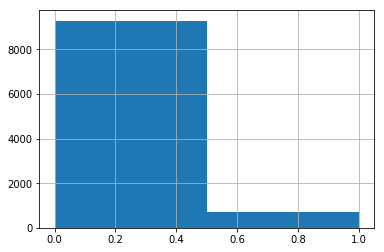

In [9]:
synthesized['type'].hist(bins=2, range=[0, 1])

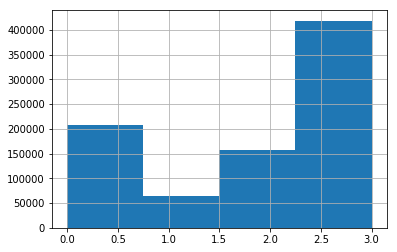

In [10]:
data['operation'].hist(bins=4, range=[0, 3])

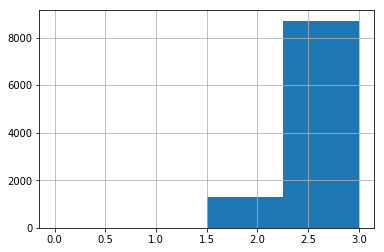

In [11]:
synthesized['operation'].hist(bins=4, range=[0, 3])

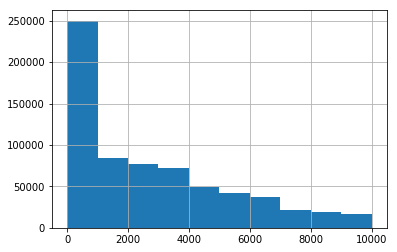

In [12]:
data['amount'].hist(bins=10, range=[0.0, 10000.0])

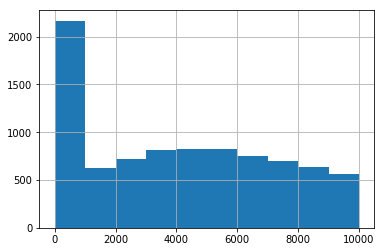

In [13]:
synthesized['amount'].hist(bins=10, range=[0.0, 10000.0])

# Tests to confirm the utility of synthetic data 

In [14]:
from synthesized.testing.testing_environment import Testing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [15]:
testing = Testing(data, synthesized)

In [27]:
testing.estimate_utility(
    continuous_columns=['amount'],  categorical_columns=['type', 'operation'],
    classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor()
)

,target_column,estimator,dummy_orig_score,original_score,dummy_synth_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,amount,DecisionTreeRegressor,0.000000,0.199652,0.000000,0.043536,8.174275e+07,9.768746e+07,0.218060,0.836778
1,operation,DecisionTreeClassifier,0.487432,0.976312,0.487432,0.516788,9.140262e-02,2.583948e+00,0.060048,0.035373
2,type,DecisionTreeClassifier,0.741016,1.000000,0.741016,0.789385,0.000000e+00,2.106148e-01,0.186765,0.000000


In [25]:
testing.compare_marginal_distributions(target_column='operation', filter_column='amount')

,amount,operation EMD
0,"[0.0, 21850.0)",0.956136
1,"[21850.0, 43700.0)",0.416705
2,"[43700.0, 65550.0)",1.000000
3,"[65550.0, 87400.0)",1.000000


In [26]:
testing.compare_marginal_distributions(target_column='type', filter_column='amount', bins=10)

,amount,type EMD
0,"[0.0, 8740.0)",0.000000
1,"[8740.0, 17480.0)",0.110425
2,"[17480.0, 26220.0)",0.301577
3,"[26220.0, 34960.0)",1.000000
4,"[34960.0, 43700.0)",1.000000
5,"[43700.0, 52440.0)",1.000000
6,"[52440.0, 61180.0)",1.000000
7,"[61180.0, 69920.0)",1.000000
8,"[69920.0, 78660.0)",1.000000
9,"[78660.0, 87400.0)",1.000000
